In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.optimize import fsolve
from scipy.interpolate import interp1d # for interpolation of new data points

sn.set_style('whitegrid')
%matplotlib inline

In [2]:
# Expanded and modified version (first column now string)
def read_table(filename,keyword='ciclo',rescale=1,ncols=5,start=2,end_row='Total',
               endword=None,omit_list=['t20_21'],index_to_int=True,debug=False):
    t0 = start
    t1 = ncols+start
    results_follow = 0
    row_names = []
    f = open(filename,'r')
    for line in f:
        words = line.split()
        if debug:
            print(words)
        if len(words)>1 and words[0] == keyword:
            results_follow=1
            if endword==None:
                colnames = words[t0:t1]
            else:
                buff_v = []
                for w in words[t0:]:
                    if w==endword:
                        break
                    else:
                        buff_v.append(w)
                colnames = buff_v[:-1]
                t1 = len(buff_v)+t0-1
            table_raw = np.empty(t1-t0)
        elif len(words)>1 and words[0] == end_row:
            break
        elif len(words)>1 and results_follow==1 and words[0] not in omit_list:
            row_names.append(words[0])
            buff_v = []
            for w in words[t0:t1]: 
                w = w.replace(",","")
                buff_v.append(w)
            table_raw = np.vstack((table_raw,np.array(buff_v,dtype=float)/rescale))
    table_raw = table_raw[1:,:]
    if debug:
        print(table_raw.shape)
        print(colnames)
    if index_to_int:
        return pd.DataFrame(table_raw, columns=colnames,index=np.array(row_names,dtype=int))
    else:
        return pd.DataFrame(table_raw, columns=colnames,index=np.array(row_names))
    
    
def file_split(filename,path,startwords=['Summary',],endword="Total",header=None):
    f = open(path+filename,'r')
    parent_file = filename[:filename.find('.')]
    di = 1
    writing = 0
    for line in f:
        words = line.split()
        if len(words)>0 and words[0] in startwords:
            sf = open(path+parent_file+'_{}.log'.format(di), "w")
            writing = 1
            if header!=None:
                sf.write(header)
        elif len(words)>0 and words[0]==endword and writing:
            sf.write(line)
            writing = 0
            sf.close()
            di+=1
        if writing:
            sf.write(line)
            
def normalise_table(table):
    cols = table.columns
    table['Total'] = table.sum(axis=1).copy()
    for col in cols:
        table[col] = table[col]/table['Total']
    return table

In [3]:
ten_data = pd.read_csv('./descriptive_stats/tenure_dist.csv')

In [4]:
years_range = ten_data['yd'].unique()
ten_data.head()

sexo1  edad5    yd state  wife  husband  mother  mother_5  mother_10  \
0      1     20  2005     T     0        0       0         0          0   
1      0     45  2005     P     0        1       0         0          0   
2      1     45  2005     P     1        0       0         0          0   
3      1     25  2005     T     0        0       0         0          0   
4      0     55  2005     P     0        0       0         0          0   

   mother_15  ...  father_state  hub_state  hub_ten_y  tenure      ten_y  \
0          0  ...           NaN        NaN        NaN       1        NaN   
1          0  ...           NaN          P  29.916666     359  29.916666   
2          0  ...           NaN          P  29.916666      48   4.000000   
3          0  ...           NaN          P  29.916666      10        NaN   
4          0  ...           NaN        NaN        NaN     387        NaN   

  wife_state  wife_ten  disc  part_time facexp  
0        NaN       NaN     0          0  11288  
1          P      48.0     0          0  18044  
2          P      48.0     0          1  18044  
3          P      48.0     0          0  18044  
4        NaN       NaN     0          0  17475  

[5 rows x 24 columns]

In [5]:
path = './plots_hist/'
kid_age_range = np.array((5,10,15))
parent_age_range = np.array([30,35,40])
ten_range = np.arange(0,31,2)
years_sample = years_range[-6:]

T = ten_range.size
Y = years_sample.size

mux = pd.MultiIndex.from_product([kid_age_range, np.hstack((parent_age_range, 3040)), years_sample,['women','men']])
MM = (parent_age_range.size+1) * kid_age_range.size * years_sample.size * 2

hist_dict, hist_dict_gross = np.zeros((T-1,MM)), np.zeros((T-1,MM))
hist_dict_w, hist_dict_gross_w = np.zeros((T-1,MM)), np.zeros((T-1,MM))
# hist_dict, hist_dict_gross = pd.DataFrame(), pd.DataFrame()

ii = 0

for kid_age in kid_age_range:

    data_fathers = ten_data[np.logical_and(ten_data['father_{}'.format(kid_age)]==1,ten_data['husband']==1)].copy()
    data_mothers = ten_data[np.logical_and(ten_data['mother_{}'.format(kid_age)]==1,ten_data['wife']==1)].copy()

    for j,age in enumerate(parent_age_range):
        for i,year in enumerate(years_sample):
            dta = data_mothers[np.logical_and(data_mothers['yd']==year,np.logical_and(data_mothers['state']=='P',
                                              np.logical_and(data_mothers['edad5']>=age,
                                                             data_mothers['edad5']<age+5)))]['tenure'].copy()/12
            ww = data_mothers[np.logical_and(data_mothers['yd']==year,np.logical_and(data_mothers['state']=='P',
                                              np.logical_and(data_mothers['edad5']>=age,
                                                             data_mothers['edad5']<age+5)))]['facexp'].copy()
            h, b = np.histogram(dta.values,bins=ten_range)
            hist_dict[:,ii],hist_dict_gross[:,ii] = h/np.sum(h), h
            
            h, b = np.histogram(dta.values,bins=ten_range,weights=ww)
            hist_dict_w[:,ii],hist_dict_gross_w[:,ii] = h/np.sum(h), h
            ii +=1
            
            dta = data_fathers[np.logical_and(data_fathers['yd']==year,np.logical_and(data_fathers['state']=='P',
                                              np.logical_and(data_fathers['edad5']>=age,
                                                             data_fathers['edad5']<age+5)))]['tenure'].copy()/12
            
            ww = data_fathers[np.logical_and(data_fathers['yd']==year,np.logical_and(data_fathers['state']=='P',
                                              np.logical_and(data_fathers['edad5']>=age,
                                                             data_fathers['edad5']<age+5)))]['facexp'].copy()
            h, b = np.histogram(dta.values,bins=ten_range)
            hist_dict[:,ii],hist_dict_gross[:,ii] = h/np.sum(h), h
            
            h, b = np.histogram(dta.values,bins=ten_range,weights=ww)
            hist_dict_w[:,ii],hist_dict_gross_w[:,ii] = h/np.sum(h), h
            ii+=1
    #Add 30-40            
    for i,year in enumerate(years_sample):
        dta = data_mothers[np.logical_and(data_mothers['yd']==year,np.logical_and(data_mothers['state']=='P',
                                          np.logical_and(data_mothers['edad5']>=30,
                                                         data_mothers['edad5']<40)))]['tenure'].copy()/12
        ww = data_mothers[np.logical_and(data_mothers['yd']==year,np.logical_and(data_mothers['state']=='P',
                                          np.logical_and(data_mothers['edad5']>=30,
                                                         data_mothers['edad5']<40)))]['facexp'].copy()
        h, b = np.histogram(dta.values,bins=ten_range)
        hist_dict[:,ii],hist_dict_gross[:,ii] = h/np.sum(h), h

        h, b = np.histogram(dta.values,bins=ten_range,weights=ww)
        hist_dict_w[:,ii],hist_dict_gross_w[:,ii] = h/np.sum(h), h
        ii +=1

        dta = data_fathers[np.logical_and(data_fathers['yd']==year,np.logical_and(data_fathers['state']=='P',
                                          np.logical_and(data_fathers['edad5']>=30,
                                                         data_fathers['edad5']<40)))]['tenure'].copy()/12

        ww = data_fathers[np.logical_and(data_fathers['yd']==year,np.logical_and(data_fathers['state']=='P',
                                          np.logical_and(data_fathers['edad5']>=30,
                                                         data_fathers['edad5']<40)))]['facexp'].copy()
        h, b = np.histogram(dta.values,bins=ten_range)
        hist_dict[:,ii],hist_dict_gross[:,ii] = h/np.sum(h), h

        h, b = np.histogram(dta.values,bins=ten_range,weights=ww)
        hist_dict_w[:,ii],hist_dict_gross_w[:,ii] = h/np.sum(h), h
        ii+=1

hist_dict, hist_dict_gross = pd.DataFrame(hist_dict,columns=mux), pd.DataFrame(hist_dict_gross,columns=mux)
hist_dict_w, hist_dict_gross_w = pd.DataFrame(hist_dict_w,columns=mux), pd.DataFrame(hist_dict_gross_w,columns=mux)

In [6]:
path = './plots_hist/'
parent_age_range = np.array([30,35,40])
ten_range = np.arange(0,31,2)
years_sample = years_range[-6:]

T = ten_range.size
Y = years_sample.size

mux = pd.MultiIndex.from_product([np.hstack((parent_age_range, 3040)),years_sample,['women','men']])
MM = (parent_age_range.size+1) * years_sample.size * 2

hist_dict_0k, hist_dict_gross_0k = np.zeros((T-1,MM)), np.zeros((T-1,MM))
hist_dict_w_0k, hist_dict_gross_w_0k = np.zeros((T-1,MM)), np.zeros((T-1,MM))

# hist_dict, hist_dict_gross = pd.DataFrame(), pd.DataFrame()

data_fathers = ten_data[np.logical_and(ten_data['father']==0,ten_data['husband']==1)].copy()
data_mothers = ten_data[np.logical_and(ten_data['mother']==0,ten_data['wife']==1)].copy()

for j,age in enumerate(parent_age_range):
    for i,year in enumerate(years_sample):       

        dta = data_mothers[np.logical_and(data_mothers['yd']==year,np.logical_and(data_mothers['state']=='P',
                                              np.logical_and(data_mothers['edad5']>=age,
                                                             data_mothers['edad5']<age+5)))]['tenure'].copy()/12
        ww = data_mothers[np.logical_and(data_mothers['yd']==year,np.logical_and(data_mothers['state']=='P',
                                              np.logical_and(data_mothers['edad5']>=age,
                                                             data_mothers['edad5']<age+5)))]['facexp'].copy()
        h, b = np.histogram(dta.values,bins=ten_range)
        hist_dict_0k[:,(i*2)+(j*Y*2)],hist_dict_gross_0k[:,(i*2)+(j*Y*2)] = h/np.sum(h), h

        h, b = np.histogram(dta.values,bins=ten_range,weights=ww)
        hist_dict_w_0k[:,(i*2)+(j*Y*2)],hist_dict_gross_w_0k[:,(i*2)+(j*Y*2)] = h/np.sum(h), h


        dta = data_fathers[np.logical_and(data_fathers['yd']==year,np.logical_and(data_fathers['state']=='P',
                                              np.logical_and(data_fathers['edad5']>=age,
                                                             data_fathers['edad5']<age+5)))]['tenure'].copy()/12

        ww = data_fathers[np.logical_and(data_fathers['yd']==year,np.logical_and(data_fathers['state']=='P',
                                              np.logical_and(data_fathers['edad5']>=age,
                                                             data_fathers['edad5']<age+5)))]['facexp'].copy()
        h, b = np.histogram(dta.values,bins=ten_range)
        hist_dict_0k[:,(i*2)+(j*Y*2)+1],hist_dict_gross_0k[:,(i*2)+(j*Y*2)+1] = h/np.sum(h), h

        h, b = np.histogram(dta.values,bins=ten_range,weights=ww)
        hist_dict_w_0k[:,(i*2)+(j*Y*2)+1],hist_dict_gross_w_0k[:,(i*2)+(j*Y*2)+1] = h/np.sum(h), h

start = (i*2)+(j*Y*2)+2

#Add 30-40            
for i,year in enumerate(years_sample):
    dta = data_mothers[np.logical_and(data_mothers['yd']==year,np.logical_and(data_mothers['state']=='P',
                                      np.logical_and(data_mothers['edad5']>=30,
                                                     data_mothers['edad5']<40)))]['tenure'].copy()/12
    ww = data_mothers[np.logical_and(data_mothers['yd']==year,np.logical_and(data_mothers['state']=='P',
                                      np.logical_and(data_mothers['edad5']>=30,
                                                     data_mothers['edad5']<40)))]['facexp'].copy()
    h, b = np.histogram(dta.values,bins=ten_range)
    hist_dict_0k[:,start+(i*2)],hist_dict_gross_0k[:,start+(i*2)] = h/np.sum(h), h

    h, b = np.histogram(dta.values,bins=ten_range,weights=ww)
    hist_dict_w_0k[:,start+i],hist_dict_gross_w_0k[:,start+(i*2)] = h/np.sum(h), h

    dta = data_fathers[np.logical_and(data_fathers['yd']==year,np.logical_and(data_fathers['state']=='P',
                                      np.logical_and(data_fathers['edad5']>=30,
                                                     data_fathers['edad5']<40)))]['tenure'].copy()/12

    ww = data_fathers[np.logical_and(data_fathers['yd']==year,np.logical_and(data_fathers['state']=='P',
                                      np.logical_and(data_fathers['edad5']>=30,
                                                     data_fathers['edad5']<40)))]['facexp'].copy()
    h, b = np.histogram(dta.values,bins=ten_range)
    hist_dict_0k[:,start+(i*2)+1],hist_dict_gross_0k[:,start+(i*2)+1] = h/np.sum(h), h

    h, b = np.histogram(dta.values,bins=ten_range,weights=ww)
    hist_dict_w_0k[:,start+(i*2)+1],hist_dict_gross_w_0k[:,start+(i*2)+1] = h/np.sum(h), h


hist_dict_0k, hist_dict_gross_0k = pd.DataFrame(hist_dict_0k,columns=mux), pd.DataFrame(hist_dict_gross_0k,columns=mux)
hist_dict_w_0k, hist_dict_gross_w_0k = pd.DataFrame(hist_dict_w_0k,columns=mux),pd.DataFrame(hist_dict_gross_w_0k,columns=mux)

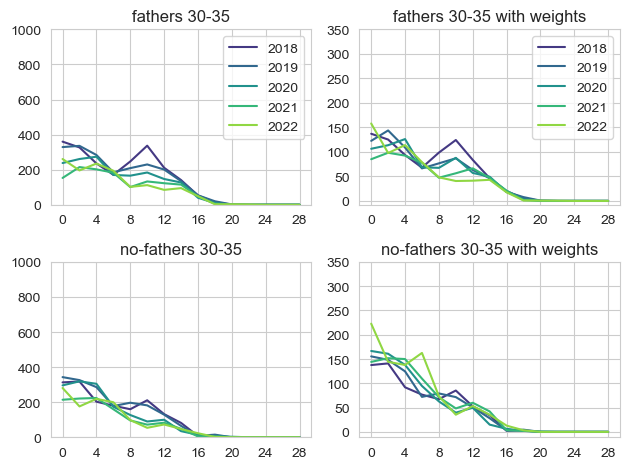

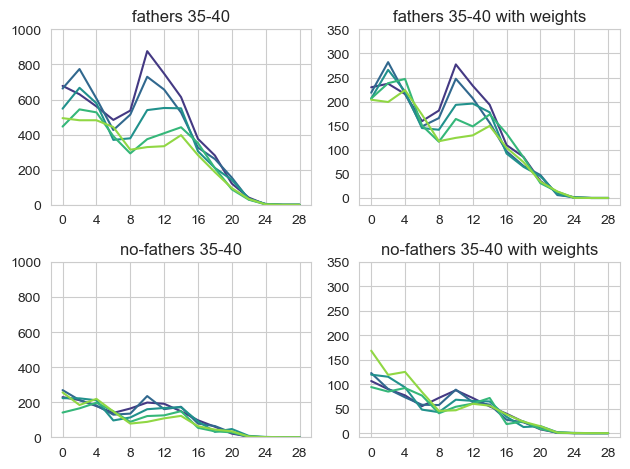

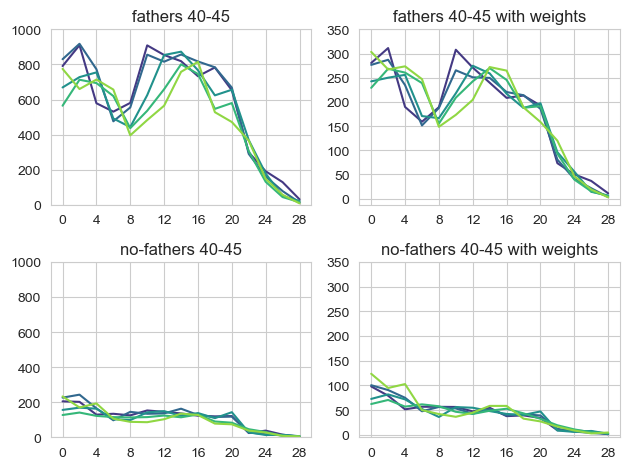

In [31]:
path = './plots_hist/'
colors = sn.color_palette('viridis',Y-1)

for age in parent_age_range:
    plt.subplot(221) # # # # # 
    plt.title('fathers {}-{}'.format(age,age+5))
    for i,year in enumerate(range(2018,2023)):
        plt.plot(ten_range[:-1],hist_dict_gross[15][age][year]['men'], color=colors[i],label=year)
    plt.xticks(ten_range[::2])
    if age==30:
        plt.legend()
    plt.ylim(0,1000)
    plt.subplot(222) # # # # # 
    plt.title('fathers {}-{} with weights'.format(age,age+5))
    for i,year in enumerate(range(2018,2023)):
        plt.plot(ten_range[:-1],hist_dict_gross_w[15][age][year]['men']/100, color=colors[i],label=year)
    plt.xticks(ten_range[::2])
    plt.yticks(np.arange(0,4e5,5e4),np.arange(0,400,50))
    if age==30:
        plt.legend()

    plt.subplot(223) # # # # # 
    plt.title('no-fathers {}-{}'.format(age,age+5))
    for i,year in enumerate(range(2018,2023)):
        plt.plot(ten_range[:-1],hist_dict_gross_0k[age][year]['men'], color=colors[i],label=year)
    plt.xticks(ten_range[::2])
    plt.ylim(0,1000)
#     plt.legend()
    plt.subplot(224) # # # # # 
    plt.title('no-fathers {}-{} with weights'.format(age,age+5))
    for i,year in enumerate(range(2018,2023)):
        plt.plot(ten_range[:-1],hist_dict_gross_w_0k[age][year]['men']/100, color=colors[i],label=year)
    plt.xticks(ten_range[::2])
    plt.yticks(np.arange(0,4e5,5e4),np.arange(0,400,50))
#     plt.legend()

    plt.tight_layout()
#     plt.savefig(path+'simple_histogram_{}_men.pdf'.format(age),bbox_inches='tight')

    plt.show()

In [35]:
export_df = np.round(hist_dict_gross_w[10]/100)
export_df = export_df.astype(int)

export_df[30].to_csv('./other_data/hist/parents30_weighted.csv')
export_df[35].to_csv('./other_data/hist/parents35_weighted.csv')
export_df[3040].to_csv('./other_data/hist/parents3040h_weighted.csv')

export_df[30].to_latex('./other_data/hist/parents30_weighted.tex')
export_df[35].to_latex('./other_data/hist/parents35_weighted.tex')
export_df[3040].to_latex('./other_data/hist/parents3040_weighted.tex')

export_df = np.round(hist_dict_gross_w_0k/100)
export_df = export_df.astype(int)

export_df[30].to_csv('./other_data/hist/no_parents30_weighted.csv')
export_df[35].to_csv('./other_data/hist/no_parents35_weighted.csv')
export_df[3040].to_csv('./other_data/hist/no_parents3040h_weighted.csv')

export_df[30].to_latex('./other_data/hist/no_parents30_weighted.tex')
export_df[35].to_latex('./other_data/hist/no_parents35_weighted.tex')
export_df[3040].to_latex('./other_data/hist/no_parents3040_weighted.tex')

C:\Users\lafuentemart\AppData\Local\Temp\ipykernel_8564\3951794810.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  export_df[30].to_latex('./other_data/hist/parents30_weighted.tex')
C:\Users\lafuentemart\AppData\Local\Temp\ipykernel_8564\3951794810.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  export_df[35].to_latex('./other_data/hist/parents35_weighted.tex')
C:\Users\lafuentemart\AppData\Local\Temp\ipykernel_8564\3951794810.py:10: FutureWarning: In future version

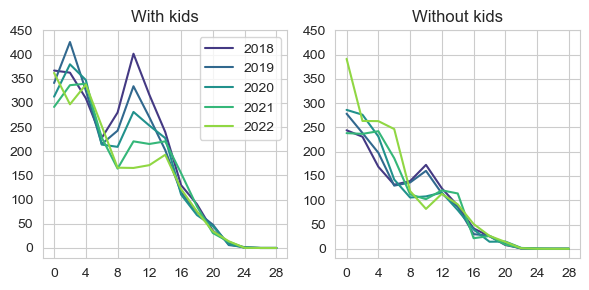

In [44]:
age = 3040
plt.figure(figsize=(6,3))
# plt.subplot(221) # # # # # 
# plt.title('fathers 30-40')
# for i,year in enumerate(range(2018,2023)):
#     plt.plot(ten_range[:-1],hist_dict_gross[15][age][year]['men'], color=colors[i],label=year)
# plt.xticks(ten_range[::2])
# if age==30:
#     plt.legend()
# plt.ylim(0,1250)

plt.subplot(121) # # # # # 
plt.title('With kids')
for i,year in enumerate(range(2018,2023)):
    plt.plot(ten_range[:-1],hist_dict_gross_w[15][age][year]['men']/100, color=colors[i],label=year)
plt.xticks(ten_range[::2])
plt.yticks(np.arange(0,5e5,5e4),np.arange(0,500,50))
plt.legend()

# plt.subplot(223) # # # # # 
# plt.title('no-fathers 30-40')
# for i,year in enumerate(range(2018,2023)):
#     plt.plot(ten_range[:-1],hist_dict_gross_0k[age][year]['men'], color=colors[i],label=year)
# plt.xticks(ten_range[::2])
# plt.ylim(0,1250)
# #     plt.legend()
plt.subplot(122) # # # # # 
plt.title('Without kids')
for i,year in enumerate(range(2018,2023)):
    plt.plot(ten_range[:-1],hist_dict_gross_w_0k[age][year]['men']/100, color=colors[i],label=year)
plt.xticks(ten_range[::2])
plt.yticks(np.arange(0,5e5,5e4),np.arange(0,500,50))
#     plt.legend()

plt.tight_layout()
plt.savefig(path+'simple_histogram_3040_men_w.pdf',bbox_inches='tight')

plt.show()

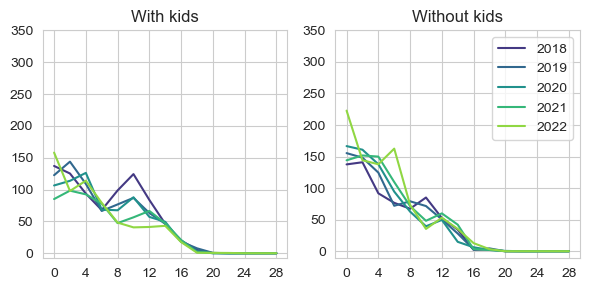

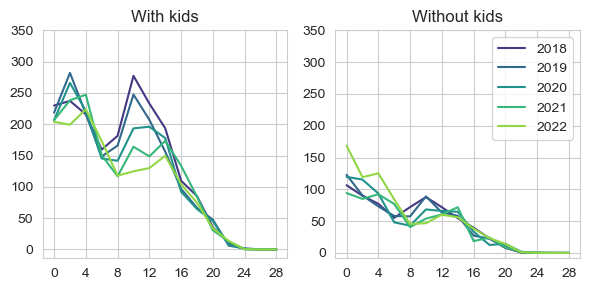

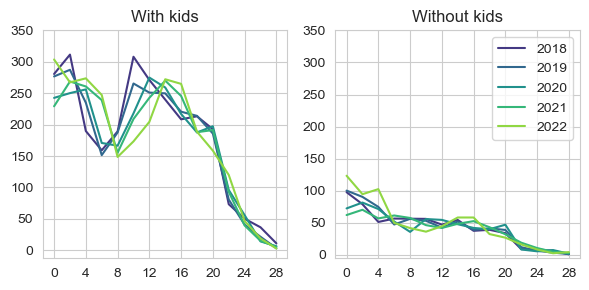

In [45]:
path = './plots_hist/'
colors = sn.color_palette('viridis',Y-1)

for age in parent_age_range:
    plt.figure(figsize=(6,3))
    plt.subplot(121) # # # # # 
#     plt.title('Men with kids {}-{}'.format(age,age+5),y=1.025)
    plt.title('With kids')
    for i,year in enumerate(range(2018,2023)):
        plt.plot(ten_range[:-1],hist_dict_gross_w[15][age][year]['men']/100, color=colors[i],label=year)
    plt.xticks(ten_range[::2])
    plt.yticks(np.arange(0,4e5,5e4),np.arange(0,400,50))
        
    plt.subplot(122) # # # # # 
#     plt.title('Men without kids {}-{}'.format(age,age+5),y=1.025)
    plt.title('Without kids')
    for i,year in enumerate(range(2018,2023)):
        plt.plot(ten_range[:-1],hist_dict_gross_w_0k[age][year]['men']/100, color=colors[i],label=year)
    plt.xticks(ten_range[::2])
    plt.yticks(np.arange(0,4e5,5e4),np.arange(0,400,50))
    plt.legend()

    plt.tight_layout()
    plt.savefig(path+'simple_histogram_{}_men_w.pdf'.format(age),bbox_inches='tight')

    plt.show()

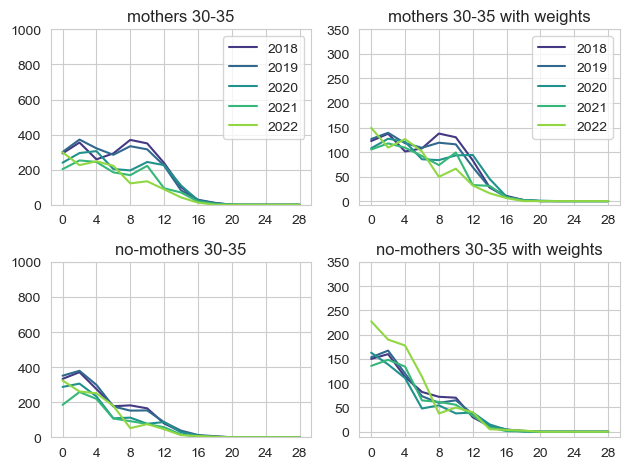

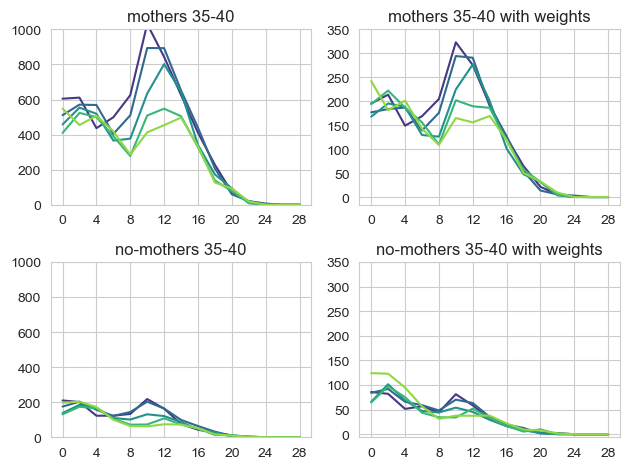

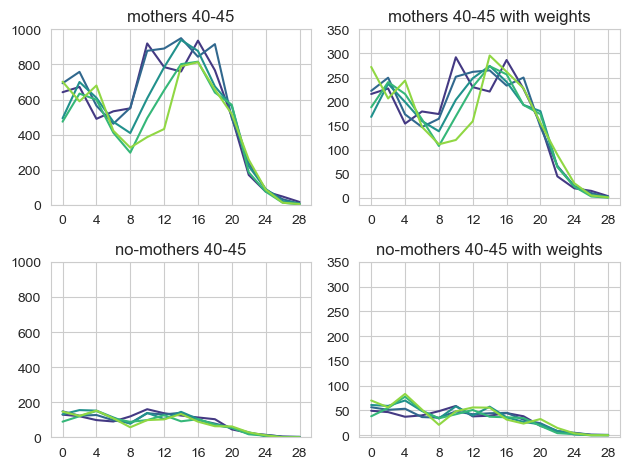

In [69]:
path = './plots_hist/'
colors = sn.color_palette('viridis',Y-1)

for age in parent_age_range:
    plt.subplot(221) # # # # # 
    plt.title('mothers {}-{}'.format(age,age+5))
    for i,year in enumerate(range(2018,2023)):
        plt.plot(ten_range[:-1],hist_dict_gross[15][age][year]['women'], color=colors[i],label=year)
    plt.xticks(ten_range[::2])
    if age==30:
        plt.legend()
    plt.ylim(0,1000)
    plt.subplot(222) # # # # # 
    plt.title('mothers {}-{} with weights'.format(age,age+5))
    for i,year in enumerate(range(2018,2023)):
        plt.plot(ten_range[:-1],hist_dict_gross_w[15][age][year]['women']/100, color=colors[i],label=year)
    plt.xticks(ten_range[::2])
    plt.yticks(np.arange(0,4e5,5e4),np.arange(0,400,50))
    if age==30:
        plt.legend()

    plt.subplot(223) # # # # # 
    plt.title('no-mothers {}-{}'.format(age,age+5))
    for i,year in enumerate(range(2018,2023)):
        plt.plot(ten_range[:-1],hist_dict_gross_0k[age][year]['women'], color=colors[i],label=year)
    plt.xticks(ten_range[::2])
    plt.ylim(0,1000)
#     plt.legend()
    plt.subplot(224) # # # # # 
    plt.title('no-mothers {}-{} with weights'.format(age,age+5))
    for i,year in enumerate(range(2018,2023)):
        plt.plot(ten_range[:-1],hist_dict_gross_w_0k[age][year]['women']/100, color=colors[i],label=year)
    plt.xticks(ten_range[::2])
    plt.yticks(np.arange(0,4e5,5e4),np.arange(0,400,50))
#     plt.legend()

    plt.tight_layout()
    plt.savefig(path+'simple_histogram_{}_women.pdf'.format(age),bbox_inches='tight')

    plt.show()

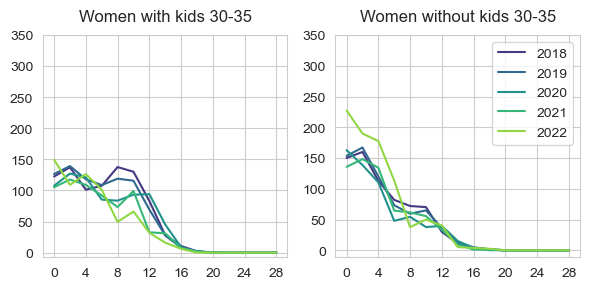

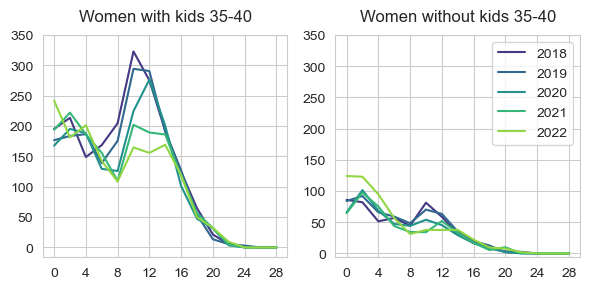

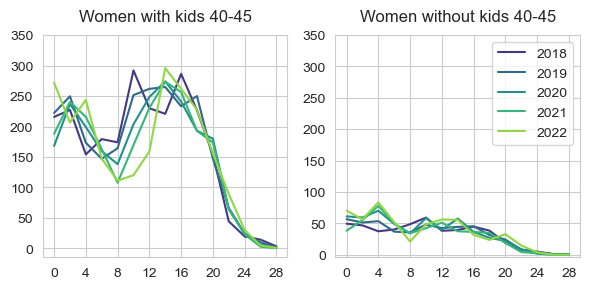

In [80]:
path = './plots_hist/'
colors = sn.color_palette('viridis',Y-1)

for age in parent_age_range:
    plt.figure(figsize=(6,3))
    plt.subplot(121) # # # # # 
    plt.title('Women with kids {}-{}'.format(age,age+5),y=1.025)
    for i,year in enumerate(range(2018,2023)):
        plt.plot(ten_range[:-1],hist_dict_gross_w[15][age][year]['women']/100, color=colors[i],label=year)
    plt.xticks(ten_range[::2])
    plt.yticks(np.arange(0,4e5,5e4),np.arange(0,400,50))
        
    plt.subplot(122) # # # # # 
    plt.title('Women without kids {}-{}'.format(age,age+5),y=1.025)
    for i,year in enumerate(range(2018,2023)):
        plt.plot(ten_range[:-1],hist_dict_gross_w_0k[age][year]['women']/100, color=colors[i],label=year)
    plt.xticks(ten_range[::2])
    plt.yticks(np.arange(0,4e5,5e4),np.arange(0,400,50))
    plt.legend()

    plt.tight_layout()
    plt.savefig(path+'simple_histogram_{}_women_w.pdf'.format(age),bbox_inches='tight')

    plt.show()

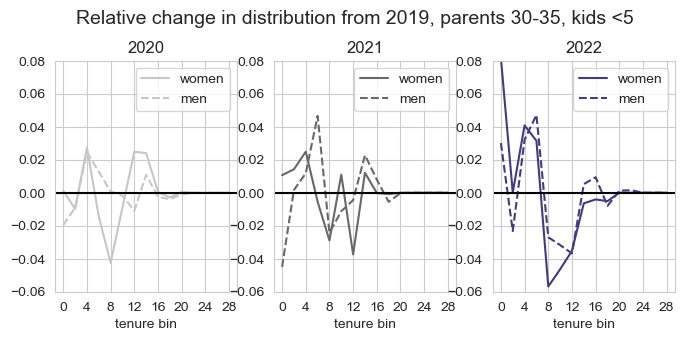

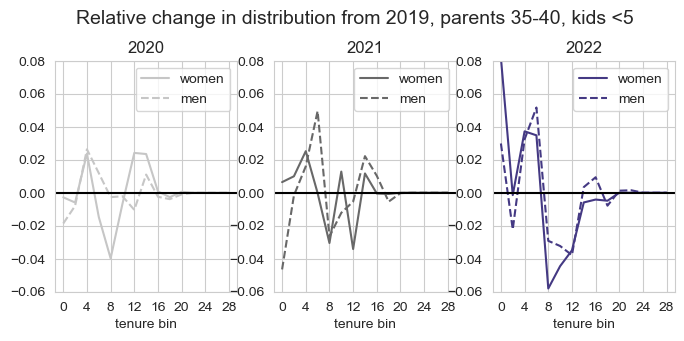

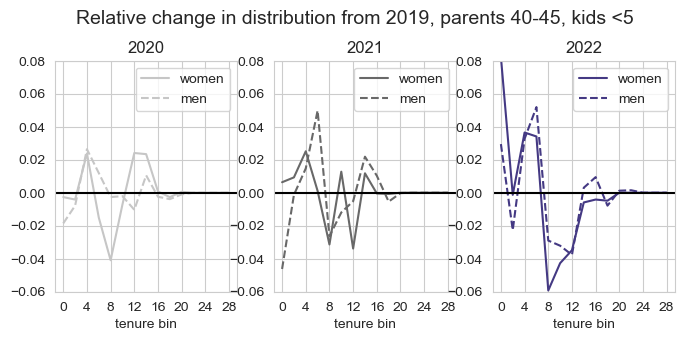

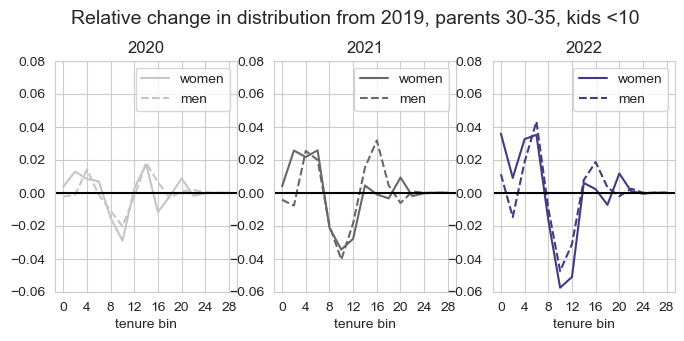

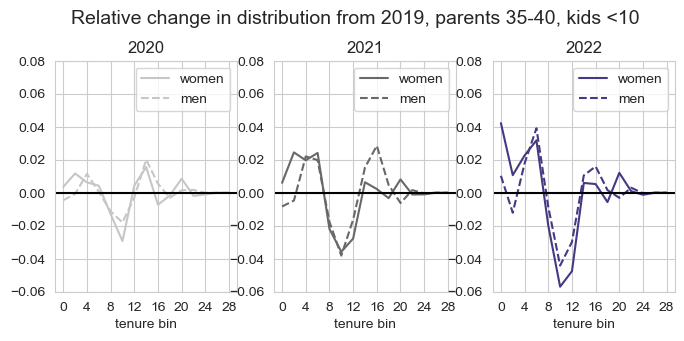

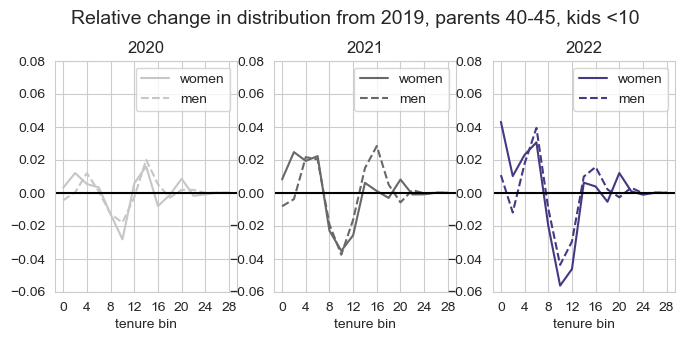

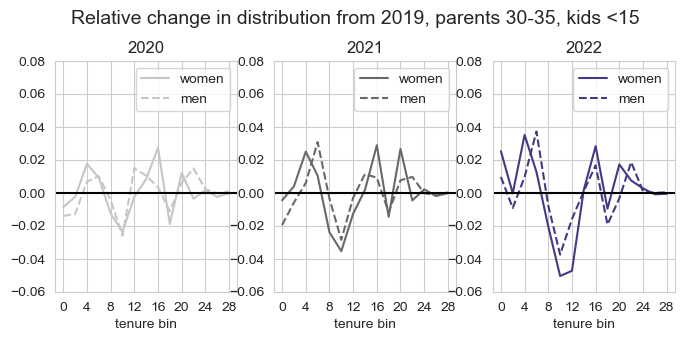

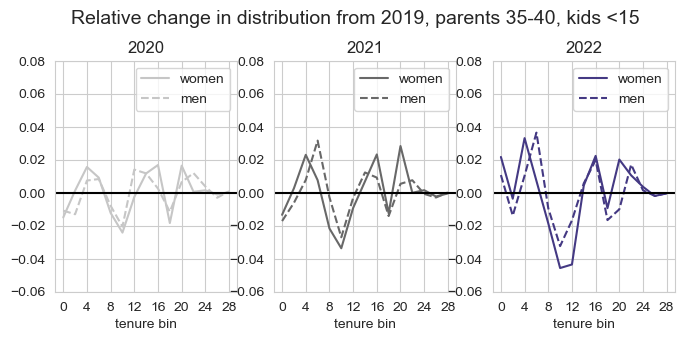

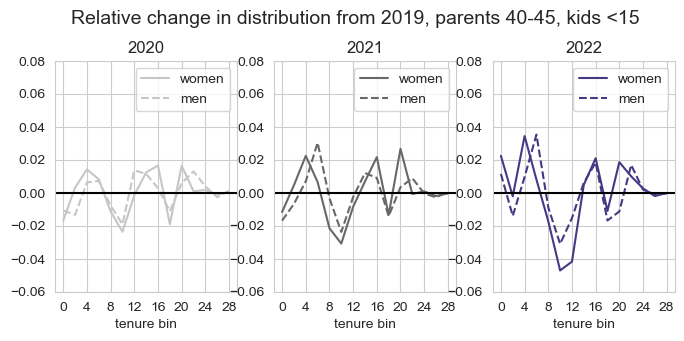

In [22]:
colors = sn.color_palette('Greys',2) + sn.color_palette('viridis',Y-1)
years_sample_19 = years_sample[years_sample>2019]
Y19 = years_sample_19.size

for k_age in kid_age_range:
    for p_age in parent_age_range:

        hist_diff_m = np.zeros((T-1,Y19))
        hist_diff_w = np.zeros((T-1,Y19))
        for i,year in enumerate(years_sample_19):
            hist_diff_w[:,i] = hist_dict[p_age][k_age][year]['women']-hist_dict[p_age][k_age][2019]['women']
            hist_diff_m[:,i] = hist_dict[p_age][k_age][year]['men']-hist_dict[p_age][k_age][2019]['men']

        plt.figure(figsize=(8,3))
        name = 'parents {}-{}, kids <{}'.format(p_age,p_age+5,k_age)
        plt.suptitle('Relative change in distribution from 2019, {}'.format(name),fontsize=14,y=1.05)
        for i,year in enumerate(years_sample_19):
            plt.subplot(131+i)
            plt.title("{}".format(year))
            plt.plot(ten_range[:-1],hist_diff_w[:,i],c=colors[i],label='women')
            plt.plot(ten_range[:-1],hist_diff_m[:,i],c=colors[i],ls='--',label='men')
            plt.xticks(ten_range[::2])
            plt.xlabel('tenure bin')
            plt.axhline(0,c='k')
            plt.ylim(-0.06,0.08)
            plt.legend()
#         plt.savefig(path+name.replace(" ","_").replace(",","").replace("<","")+'_2019_relative_both.pdf',bbox_inches='tight')
        plt.show()

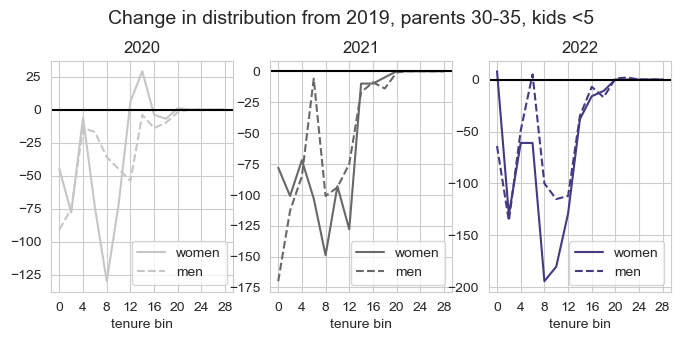

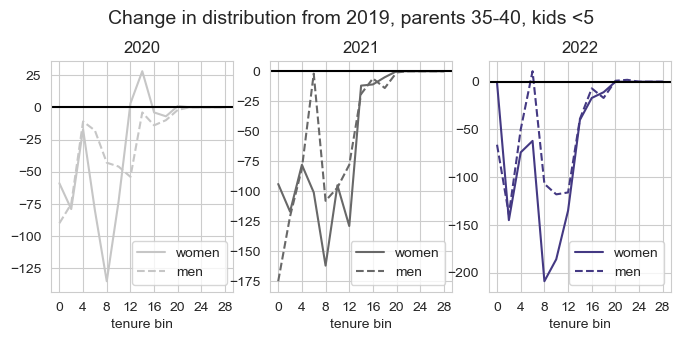

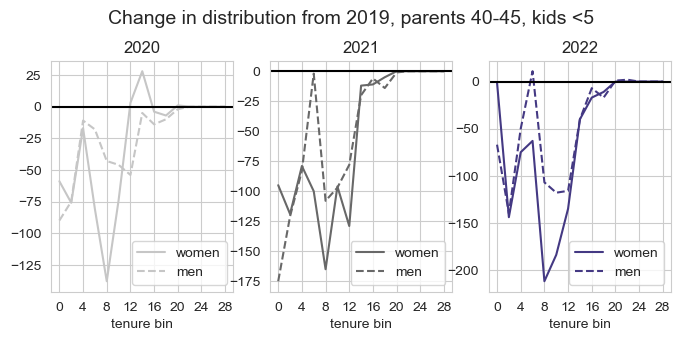

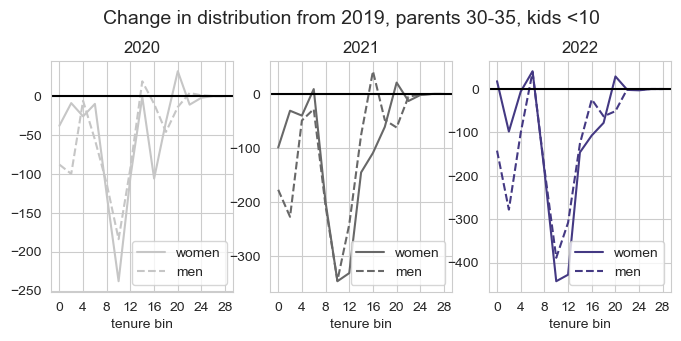

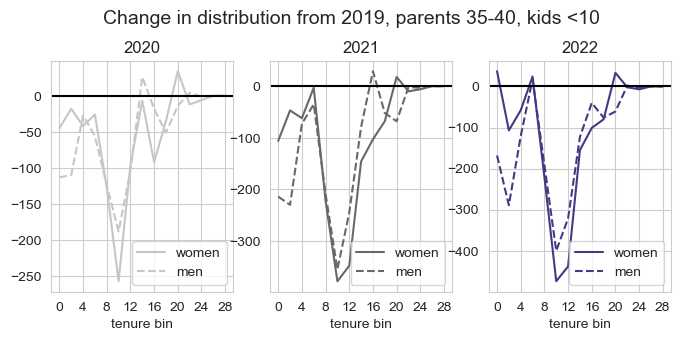

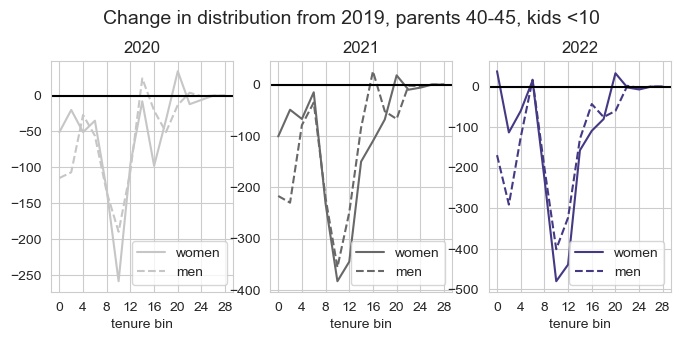

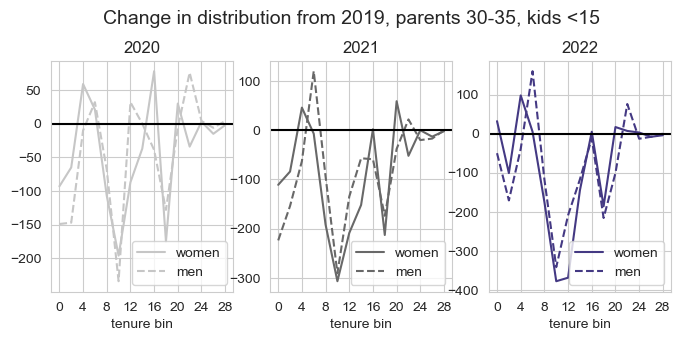

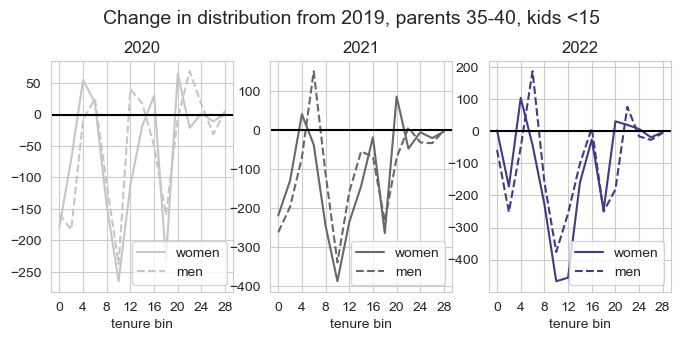

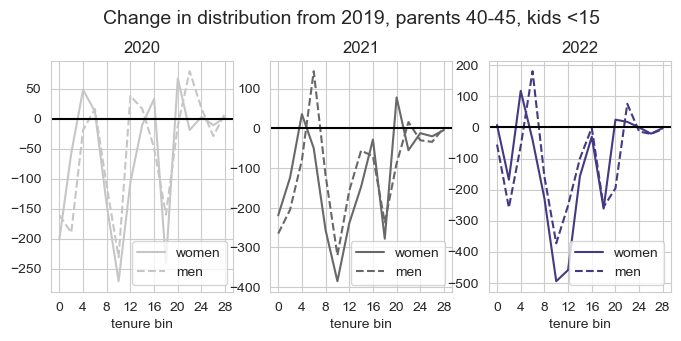

In [17]:
colors = sn.color_palette('Greys',2) + sn.color_palette('viridis',Y-1)
years_sample_19 = years_sample[years_sample>2019]
Y19 = years_sample_19.size

for k_age in kid_age_range:
    for p_age in parent_age_range:

        hist_diff_gross_m = np.zeros((T-1,Y19))
        hist_diff_gross_w = np.zeros((T-1,Y19))
        for i,year in enumerate(years_sample_19):
            hist_diff_gross_w[:,i] = hist_dict_gross[p_age][k_age][year]['women']-hist_dict_gross[p_age][k_age][2019]['women']
            hist_diff_gross_m[:,i] = hist_dict_gross[p_age][k_age][year]['men']-hist_dict_gross[p_age][k_age][2019]['men']

        plt.figure(figsize=(8,3))
        name = 'parents {}-{}, kids <{}'.format(p_age,p_age+5,k_age)
        plt.suptitle('Change in distribution from 2019, {}'.format(name),fontsize=14,y=1.05)
        for i,year in enumerate(years_sample_19):
            plt.subplot(131+i)
            plt.title("{}".format(year))
            plt.plot(ten_range[:-1],hist_diff_gross_w[:,i],c=colors[i],label='women')
            plt.plot(ten_range[:-1],hist_diff_gross_m[:,i],c=colors[i],ls='--',label='men')
            plt.xticks(ten_range[::2])
            plt.xlabel('tenure bin')
            plt.axhline(0,c='k')
#             plt.ylim(-0.05,0.05)
            plt.legend()
        plt.savefig(path+name.replace(" ","_").replace(",","").replace("<","")+'_2019_both.pdf',bbox_inches='tight')
        plt.show()

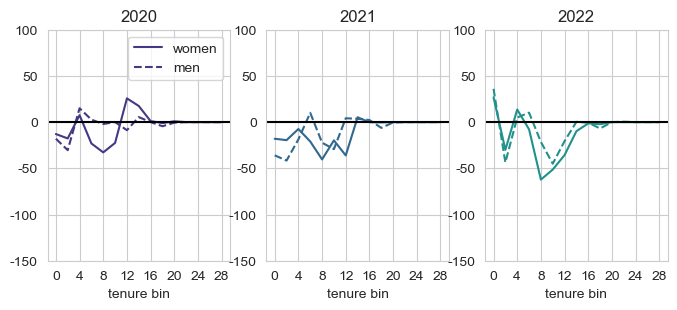

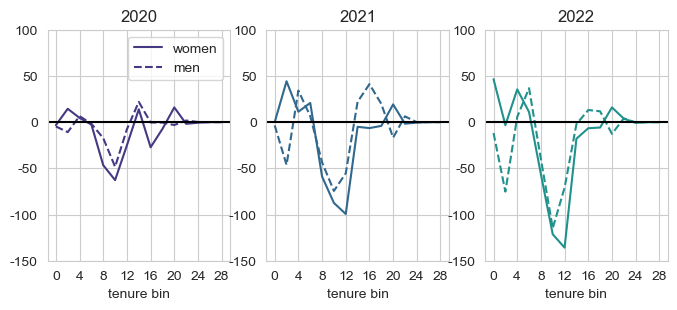

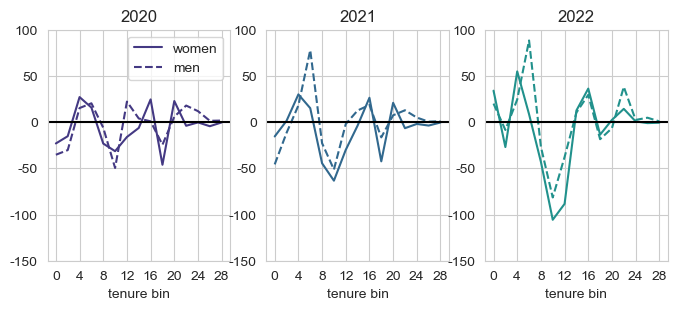

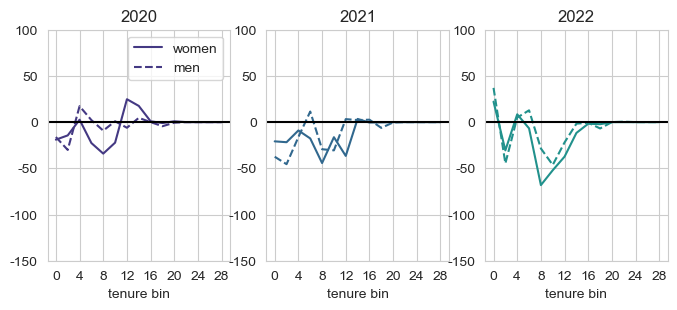

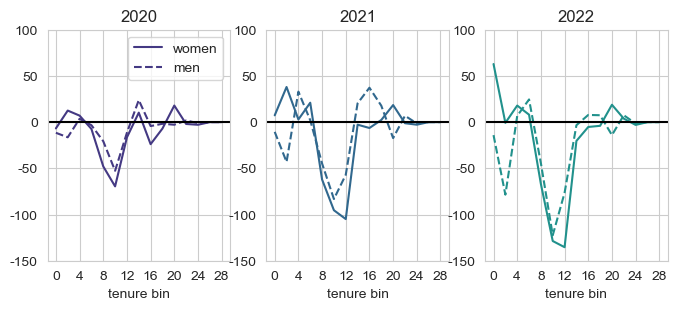

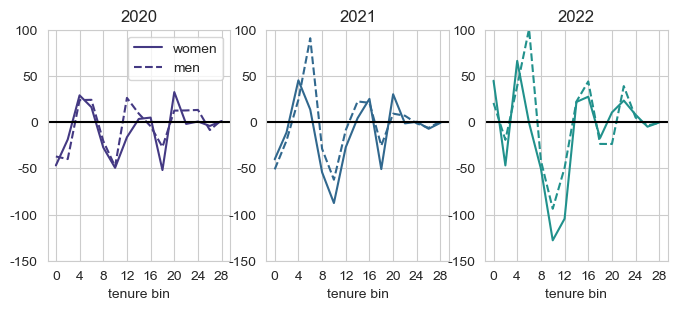

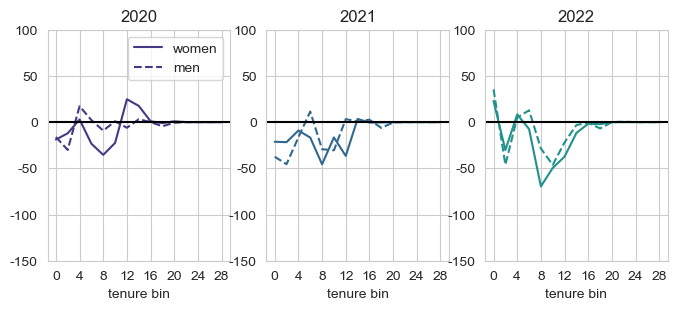

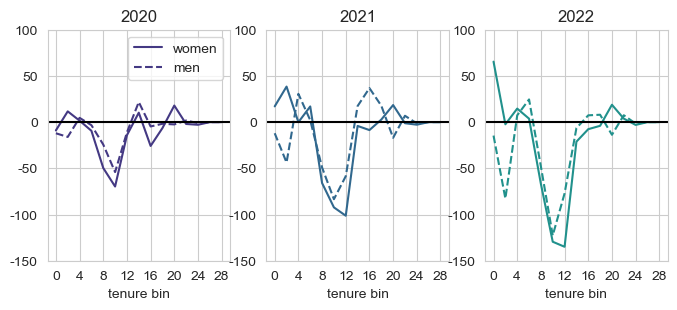

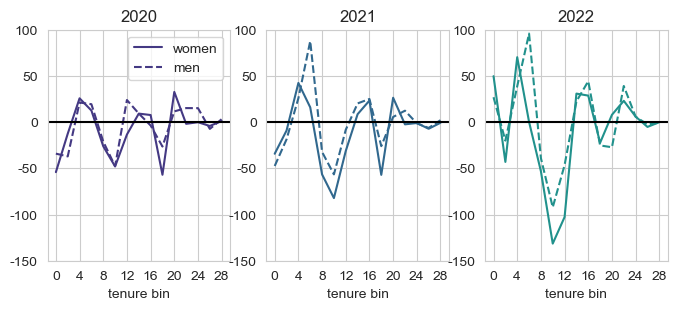

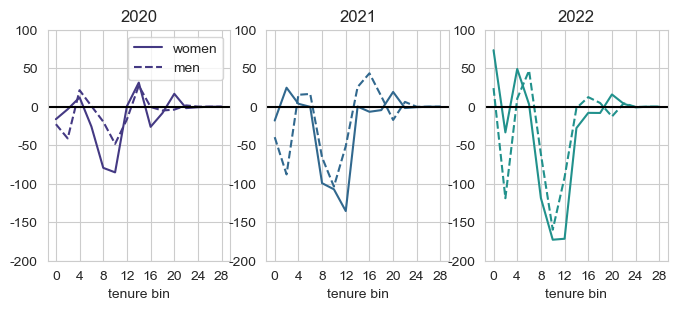

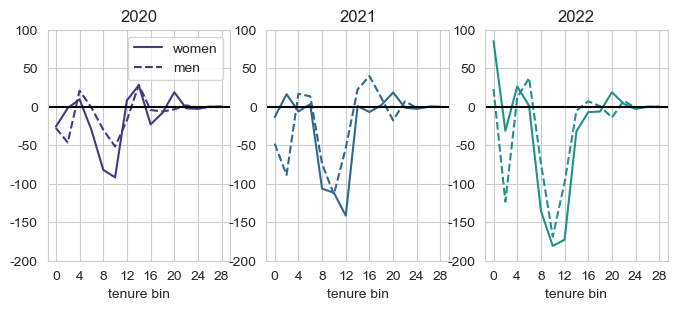

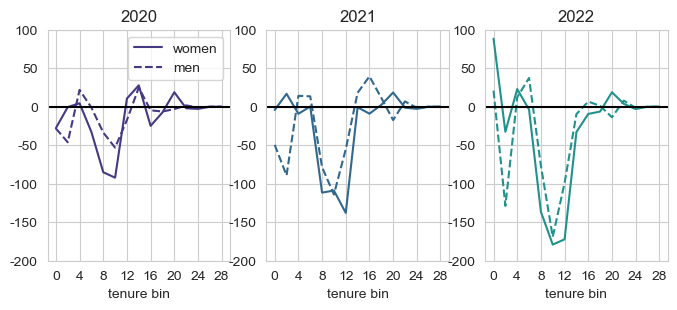

In [7]:
colors = sn.color_palette('viridis',Y-1)
years_sample_19 = years_sample[years_sample>2019]
Y19 = years_sample_19.size

mux = pd.MultiIndex.from_product([kid_age_range,np.hstack((parent_age_range, 3040)),years_sample_19,['women','men']])
MM = kid_age_range.size * (parent_age_range.size+1) * years_sample_19.size * 2

export_data = np.zeros((T-1,MM))

ii = 0
for k_age in kid_age_range:
    for p_age in parent_age_range:

        hist_diff_gross_w_m = np.zeros((T-1,Y19))
        hist_diff_gross_w_w = np.zeros((T-1,Y19))
        for i,year in enumerate(years_sample_19):
            hist_diff_gross_w_w[:,i] = hist_dict_gross_w[k_age][p_age][year]['women']-hist_dict_gross_w[k_age][p_age][2019]['women']
            hist_diff_gross_w_m[:,i] = hist_dict_gross_w[k_age][p_age][year]['men']-hist_dict_gross_w[k_age][p_age][2019]['men']
            export_data[:,ii] =  hist_diff_gross_w_w[:,i]/100
            ii+=1
            export_data[:,ii] =  hist_diff_gross_w_m[:,i]/100
            ii+=1
        plt.figure(figsize=(8,3))
        name = 'parents {}-{}, kids <{}'.format(p_age,p_age+5,k_age)
#         plt.suptitle('Change in distribution from 2019, {}'.format(name),fontsize=14,y=1.05)
        for i,year in enumerate(years_sample_19):
            plt.subplot(131+i)
            plt.title("{}".format(year))
            plt.plot(ten_range[:-1],hist_diff_gross_w_w[:,i]/100,c=colors[i],label='women')
            plt.plot(ten_range[:-1],hist_diff_gross_w_m[:,i]/100,c=colors[i],ls='--',label='men')
            plt.xticks(ten_range[::2])
            plt.xlabel('tenure bin')
            plt.axhline(0,c='k')
            plt.ylim(-1.5e5,1e5)
            plt.yticks(np.arange(-1.5e5,1.5e5,5e4),np.arange(-150,150,50))
            if i==0:
                plt.legend()
        plt.savefig(path+name.replace(" ","_").replace(",","").replace("<","")+'_2019_both_weighted.pdf',bbox_inches='tight')
        plt.show()

p_age = 3040
for k_age in kid_age_range:
    hist_diff_gross_w_m = np.zeros((T-1,Y19))
    hist_diff_gross_w_w = np.zeros((T-1,Y19))
    for i,year in enumerate(years_sample_19):
        hist_diff_gross_w_w[:,i] = hist_dict_gross_w[k_age][p_age][year]['women']-hist_dict_gross_w[k_age][p_age][2019]['women']
        hist_diff_gross_w_m[:,i] = hist_dict_gross_w[k_age][p_age][year]['men']-hist_dict_gross_w[k_age][p_age][2019]['men']
        export_data[:,ii] =  hist_diff_gross_w_w[:,i]/100
        ii+=1
        export_data[:,ii] =  hist_diff_gross_w_m[:,i]/100
        ii+=1
    plt.figure(figsize=(8,3))
    name = 'parents 30-40, kids <{}'.format(k_age)
#         plt.suptitle('Change in distribution from 2019, {}'.format(name),fontsize=14,y=1.05)
    for i,year in enumerate(years_sample_19):
        plt.subplot(131+i)
        plt.title("{}".format(year))
        plt.plot(ten_range[:-1],hist_diff_gross_w_w[:,i]/100,c=colors[i],label='women')
        plt.plot(ten_range[:-1],hist_diff_gross_w_m[:,i]/100,c=colors[i],ls='--',label='men')
        plt.xticks(ten_range[::2])
        plt.xlabel('tenure bin')
        plt.axhline(0,c='k')
        plt.ylim(-2e5,1e5)
        plt.yticks(np.arange(-2e5,1.5e5,5e4),np.arange(-200,150,50))
        if i==0:
            plt.legend()
    plt.savefig(path+name.replace(" ","_").replace(",","").replace("<","")+'_2019_both_weighted.pdf',bbox_inches='tight')
    plt.show()

In [16]:
export_df = pd.DataFrame(export_data,columns=mux,index=ten_range[1:])
# mux2 = pd.MultiIndex.from_product([kid_age_range,np.hstack((parent_age_range, 3040)),['women','men'],years_sample_19])

# export_df = export_df.T.set_index(mux2).T.astype(int)
export_df[10][30].to_csv('./other_data/hist/parents30_2019_both_weighted.csv')
export_df[10][35].to_csv('./other_data/hist/parents35_2019_both_weighted.csv')
export_df[10][3040].to_csv('./other_data/hist/parents3040_2019_both_weighted.csv')

export_df[10][30].to_latex('./other_data/hist/parents30_2019_both_weighted.tex')
export_df[10][35].to_latex('./other_data/hist/parents35_2019_both_weighted.tex')
export_df[10][3040].to_latex('./other_data/hist/parents3040_2019_both_weighted.tex')

C:\Users\lafuentemart\AppData\Local\Temp\ipykernel_8564\5965379.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  export_df[10][30].to_latex('./other_data/hist/parents30_2019_both_weighted.tex')
C:\Users\lafuentemart\AppData\Local\Temp\ipykernel_8564\5965379.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  export_df[10][35].to_latex('./other_data/hist/parents35_2019_both_weighted.tex')
C:\Users\lafuentemart\AppData\Local\Temp\ipykernel_8564\5965379.py:11: FutureWarnin

In [17]:
mux_redux = pd.MultiIndex.from_product([kid_age_range,np.hstack((30, 35,3040)),years_sample_19])
MMR = kid_age_range.size * 3 * years_sample_19.size
export_df_diff = np.zeros((T-1,MMR))  
ii=0
for k_age in kid_age_range:
    for p_age in [30,35,3040]:
        for year in years_sample_19:
            export_df_diff[:,ii] = export_df[k_age][p_age][year]['women']- export_df[k_age][p_age][year]['men']
            ii+=1
            
export_df_diff = pd.DataFrame(export_df_diff,index=ten_range[1:],columns=mux_redux).astype(int)
export_df_diff[10][30].to_csv('./other_data/hist/parents30_2019_both_diff_weighted.csv')
export_df_diff[10][35].to_csv('./other_data/hist/parents35_2019_both_diff_weighted.csv')
export_df_diff[10][3040].to_csv('./other_data/hist/parents3040_2019_both_diff_weighted.csv')

export_df_diff[10][30].to_latex('./other_data/hist/parents30_2019_both_diff_weighted.tex')
export_df_diff[10][35].to_latex('./other_data/hist/parents35_2019_both_diff_weighted.tex')
export_df_diff[10][3040].to_latex('./other_data/hist/parents3040_2019_both_diff_weighted.tex')

C:\Users\lafuentemart\AppData\Local\Temp\ipykernel_8564\4143516696.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  export_df_diff[10][30].to_latex('./other_data/hist/parents30_2019_both_diff_weighted.tex')
C:\Users\lafuentemart\AppData\Local\Temp\ipykernel_8564\4143516696.py:17: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  export_df_diff[10][35].to_latex('./other_data/hist/parents35_2019_both_diff_weighted.tex')
C:\Users\lafuentemart\AppData\Local\Temp\ipykernel_8564\

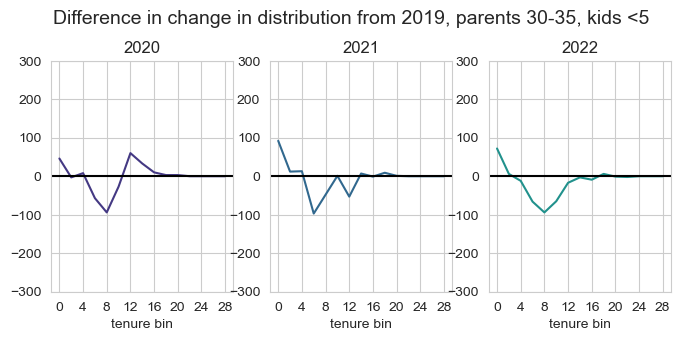

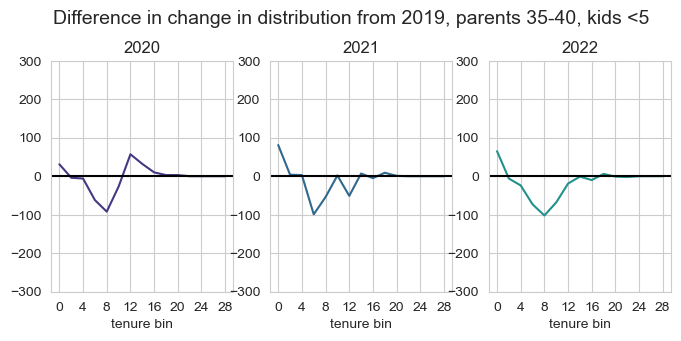

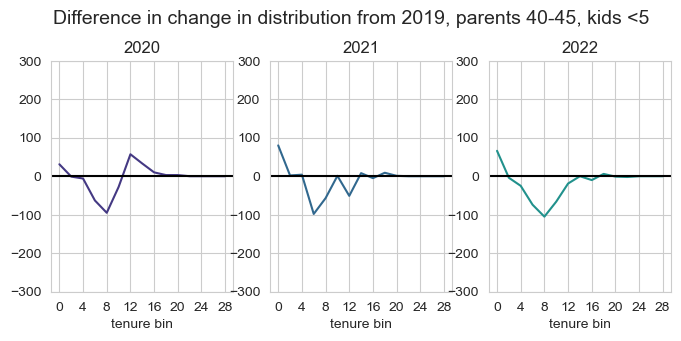

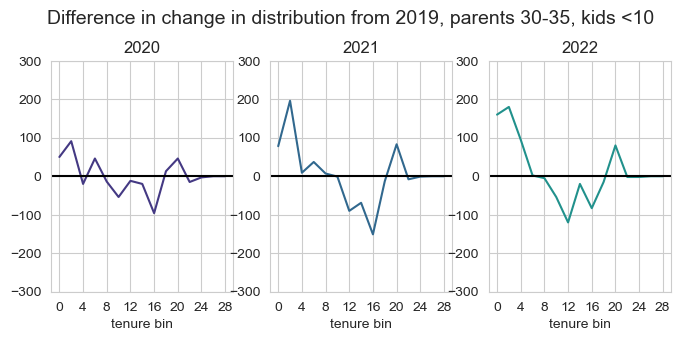

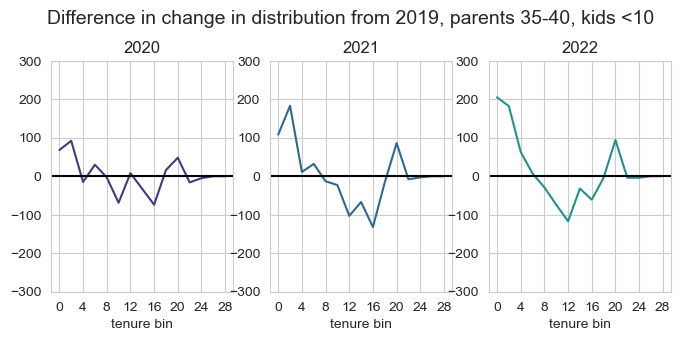

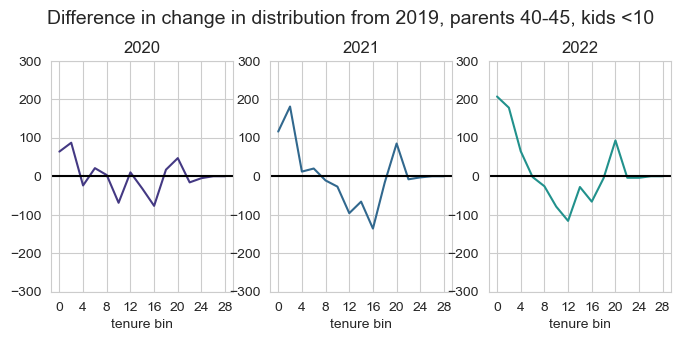

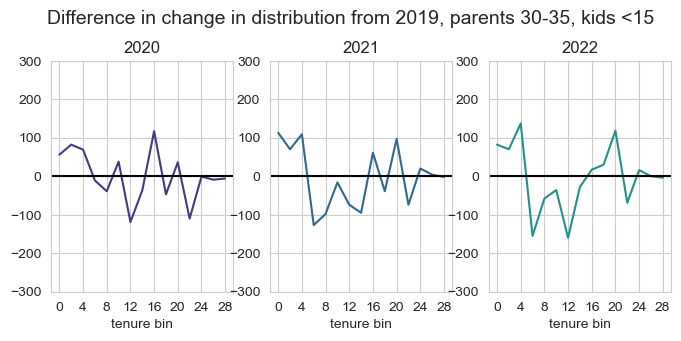

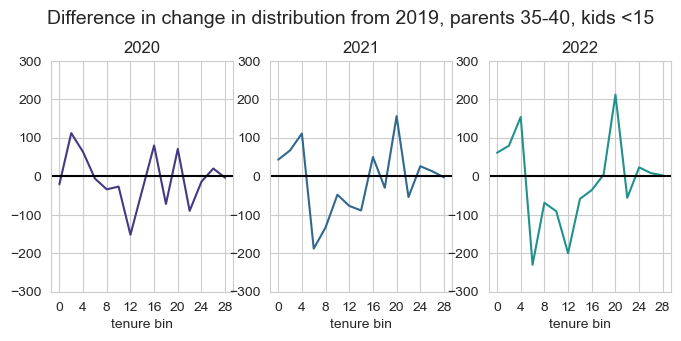

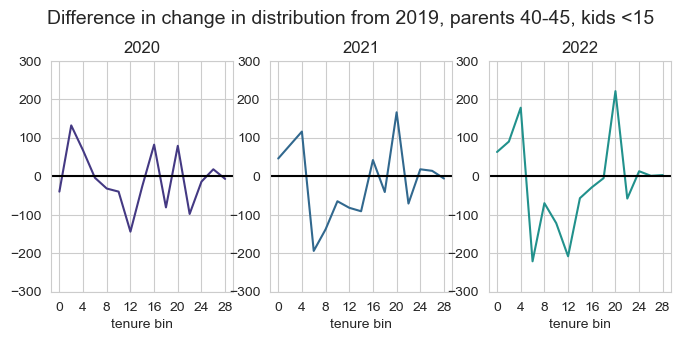

In [24]:
colors = sn.color_palette('viridis',Y-1)
years_sample_19 = years_sample[years_sample>2019]
Y19 = years_sample_19.size

for k_age in kid_age_range:
    for p_age in parent_age_range:

        hist_diff_gross_m = np.zeros((T-1,Y19))
        hist_diff_gross_w = np.zeros((T-1,Y19))
        for i,year in enumerate(years_sample_19):
            hist_diff_gross_w[:,i] = hist_dict_gross[p_age][k_age][year]['women']-hist_dict_gross[p_age][k_age][2019]['women']
            hist_diff_gross_m[:,i] = hist_dict_gross[p_age][k_age][year]['men']-hist_dict_gross[p_age][k_age][2019]['men']

        plt.figure(figsize=(8,3))
        name = 'parents {}-{}, kids <{}'.format(p_age,p_age+5,k_age)
        plt.suptitle('Difference in change in distribution from 2019, {}'.format(name),fontsize=14,y=1.05)
        for i,year in enumerate(years_sample_19):
            plt.subplot(131+i)
            plt.title("{}".format(year))
            plt.plot(ten_range[:-1],hist_diff_gross_w[:,i]-hist_diff_gross_m[:,i],c=colors[i])
            plt.xticks(ten_range[::2])
            plt.xlabel('tenure bin')
            plt.axhline(0,c='k')
            plt.ylim(-300,300)
#             plt.legend()
        plt.savefig(path+name.replace(" ","_").replace(",","").replace("<","")+'_2019_both_diff.pdf',bbox_inches='tight')
        plt.show()

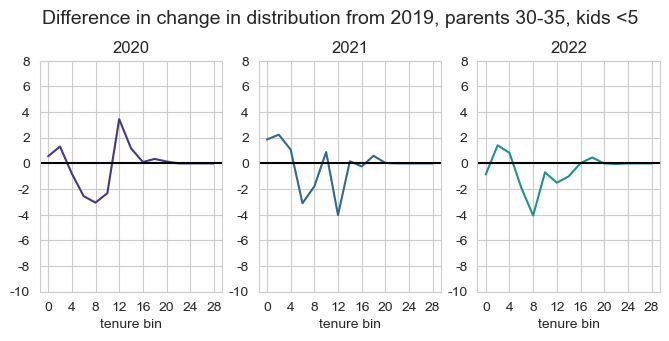

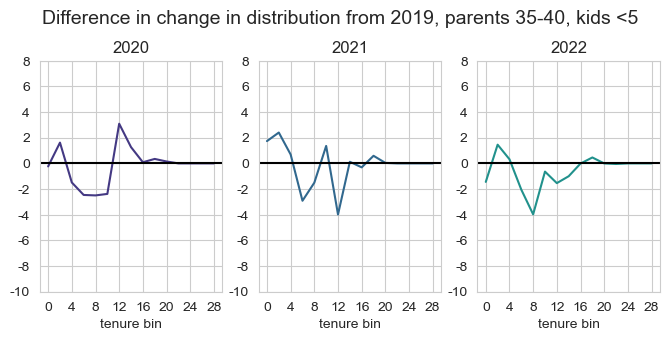

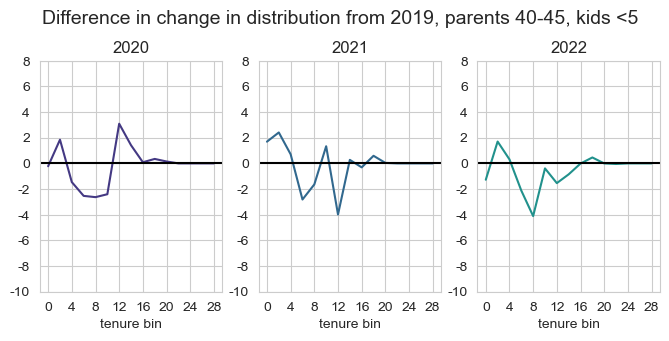

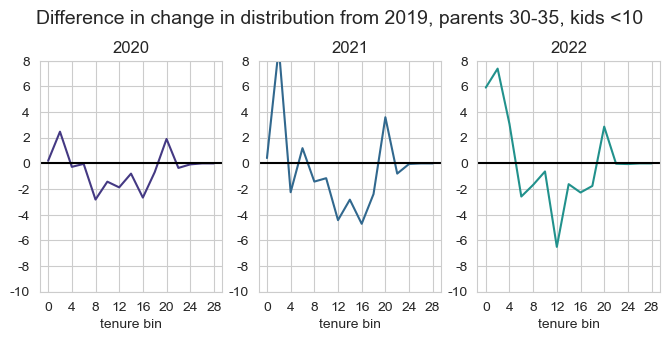

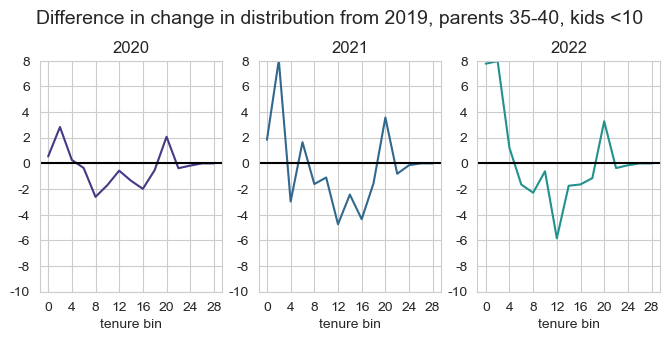

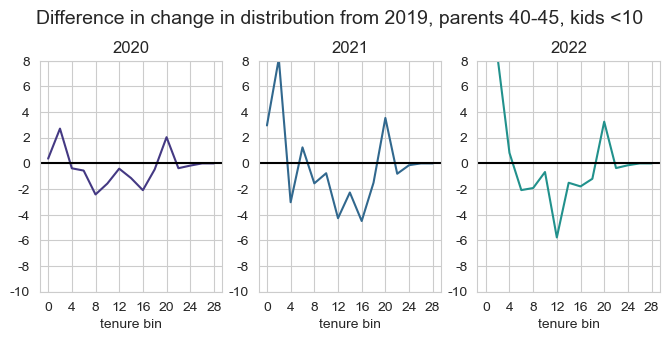

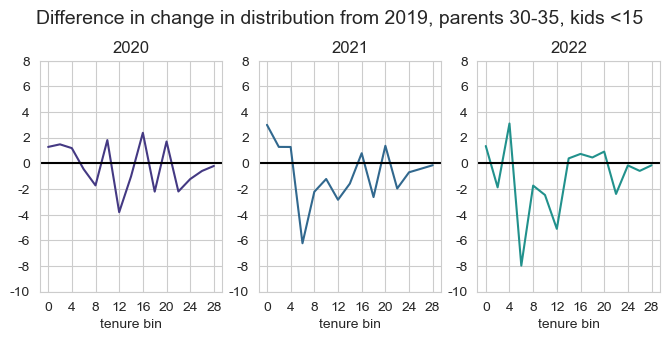

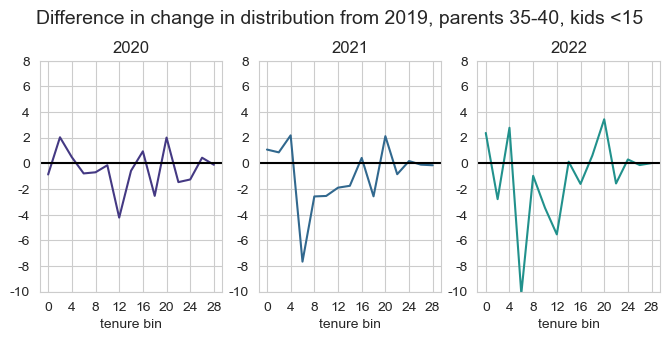

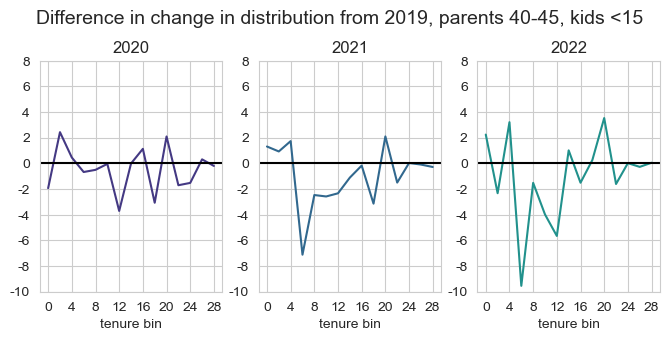

In [16]:
colors = sn.color_palette('viridis',Y-1)
years_sample_19 = years_sample[years_sample>2019]
Y19 = years_sample_19.size

for k_age in kid_age_range:
    for p_age in parent_age_range:

        hist_diff_gross_w_m = np.zeros((T-1,Y19))
        hist_diff_gross_w_w = np.zeros((T-1,Y19))
        for i,year in enumerate(years_sample_19):
            hist_diff_gross_w_w[:,i] = hist_dict_gross_w[p_age][k_age][year]['women']-hist_dict_gross_w[p_age][k_age][2019]['women']
            hist_diff_gross_w_m[:,i] = hist_dict_gross_w[p_age][k_age][year]['men']-hist_dict_gross_w[p_age][k_age][2019]['men']

        plt.figure(figsize=(8,3))
        name = 'parents {}-{}, kids <{}'.format(p_age,p_age+5,k_age)
        plt.suptitle('Difference in change in distribution from 2019, {}'.format(name),fontsize=14,y=1.05)
        for i,year in enumerate(years_sample_19):
            plt.subplot(131+i)
            plt.title("{}".format(year))
            plt.plot(ten_range[:-1],(hist_diff_gross_w_w[:,i]-hist_diff_gross_w_m[:,i])/100,c=colors[i])
            plt.xticks(ten_range[::2])
            plt.xlabel('tenure bin')
            plt.axhline(0,c='k')
            plt.ylim(-1e5,8e4)
            plt.yticks(np.arange(-1e5,10e4,2e4),np.arange(-10,10,2))
#             plt.legend()
        plt.savefig(path+name.replace(" ","_").replace(",","").replace("<","")+'_2019_weighted_both_diff.pdf',bbox_inches='tight')
        plt.show()

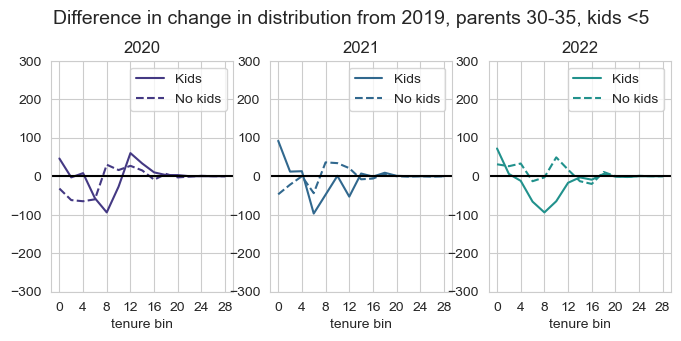

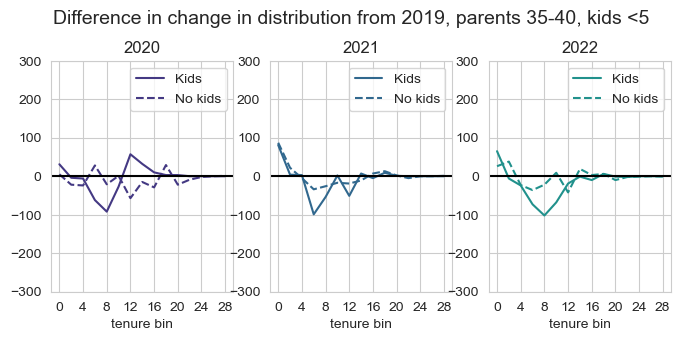

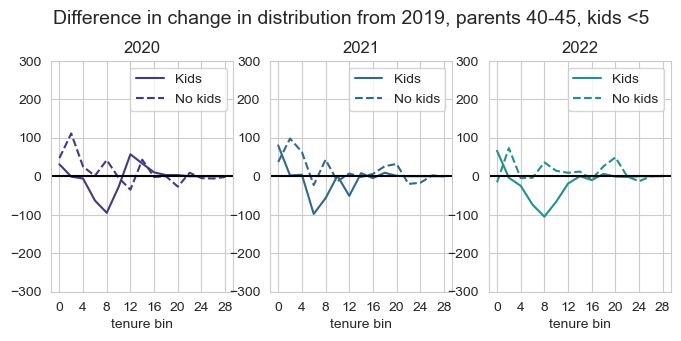

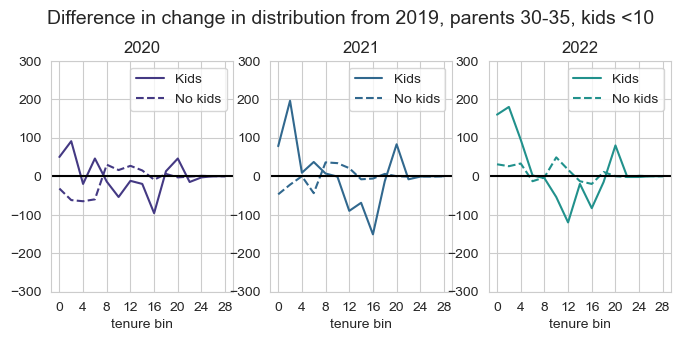

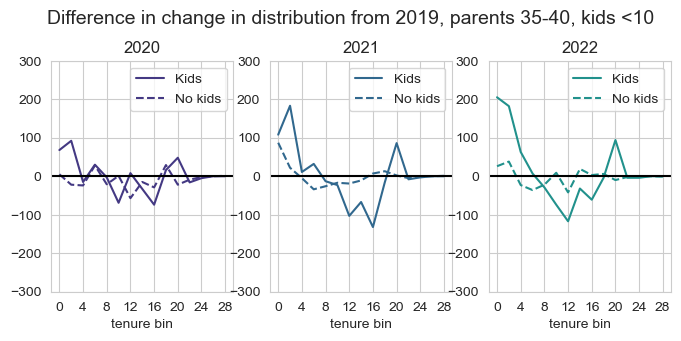

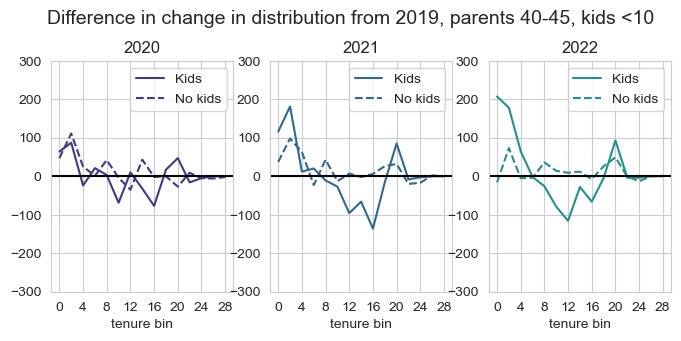

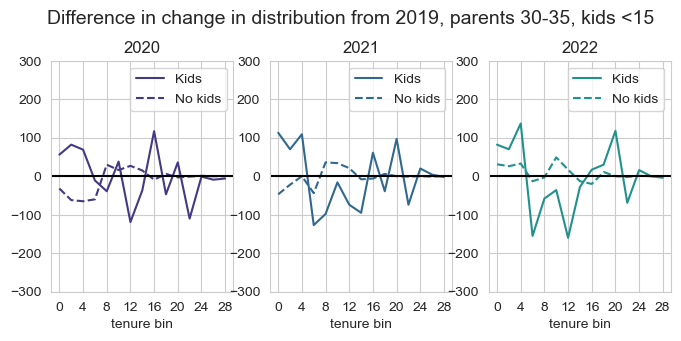

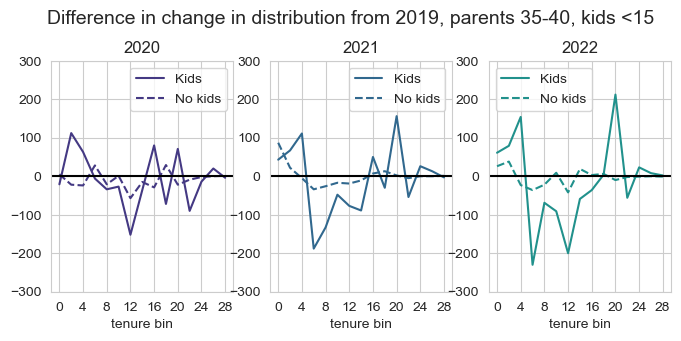

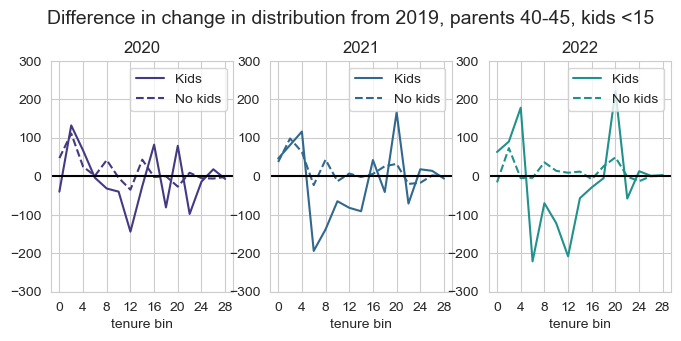

In [16]:
colors = sn.color_palette('viridis',Y-1)
years_sample_19 = years_sample[years_sample>2019]
Y19 = years_sample_19.size

for k_age in kid_age_range:
    for p_age in parent_age_range:

        hist_diff_gross_m, hist_diff_gross_m_0k = np.zeros((T-1,Y19)), np.zeros((T-1,Y19))
        hist_diff_gross_w, hist_diff_gross_w_0k = np.zeros((T-1,Y19)), np.zeros((T-1,Y19))
        for i,year in enumerate(years_sample_19):
            hist_diff_gross_w[:,i] = hist_dict_gross[k_age][p_age][year]['women']-hist_dict_gross[k_age][p_age][2019]['women']
            hist_diff_gross_m[:,i] = hist_dict_gross[k_age][p_age][year]['men']-hist_dict_gross[k_age][p_age][2019]['men']
            
            hist_diff_gross_w_0k[:,i] = hist_dict_gross_0k[p_age][year]['women']-hist_dict_gross_0k[p_age][2019]['women']
            hist_diff_gross_m_0k[:,i] = hist_dict_gross_0k[p_age][year]['men']-hist_dict_gross_0k[p_age][2019]['men']

        plt.figure(figsize=(8,3))
        name = 'parents {}-{}, kids <{}'.format(p_age,p_age+5,k_age)
        plt.suptitle('Difference in change in distribution from 2019, {}'.format(name),fontsize=14,y=1.05)
        for i,year in enumerate(years_sample_19):
            plt.subplot(131+i)
            plt.title("{}".format(year))
            plt.plot(ten_range[:-1],hist_diff_gross_w[:,i]-hist_diff_gross_m[:,i],c=colors[i], label='Kids')
            plt.plot(ten_range[:-1],hist_diff_gross_w_0k[:,i]-hist_diff_gross_m_0k[:,i],c=colors[i],ls='--',label='No kids')
            plt.xticks(ten_range[::2])
            plt.xlabel('tenure bin')
            plt.axhline(0,c='k')
            plt.ylim(-300,300)
            plt.legend()
        plt.savefig(path+name.replace(" ","_").replace(",","").replace("<","")+'_2019_all_diff.pdf',bbox_inches='tight')
        plt.show()

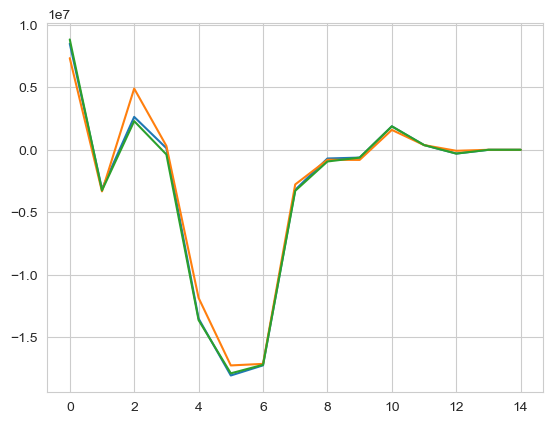

In [182]:
plt.plot(hist_dict_gross_w[10][3040][year]['women']-hist_dict_gross_w[10][3040][2019]['women'])
plt.plot(hist_dict_gross_w[5][3040][year]['women']-hist_dict_gross_w[5][3040][2019]['women'])
plt.plot(hist_dict_gross_w[15][3040][year]['women']-hist_dict_gross_w[15][3040][2019]['women'])

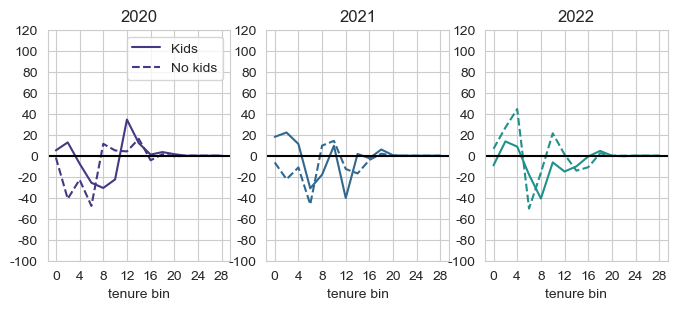

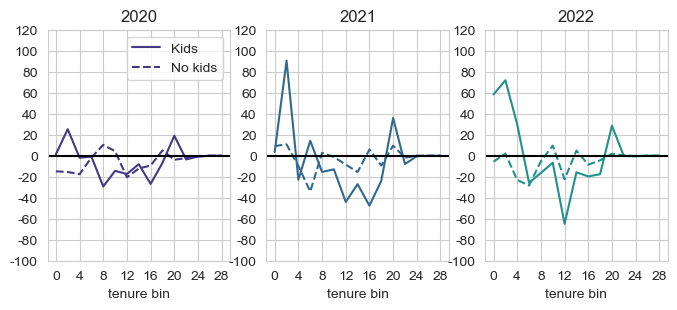

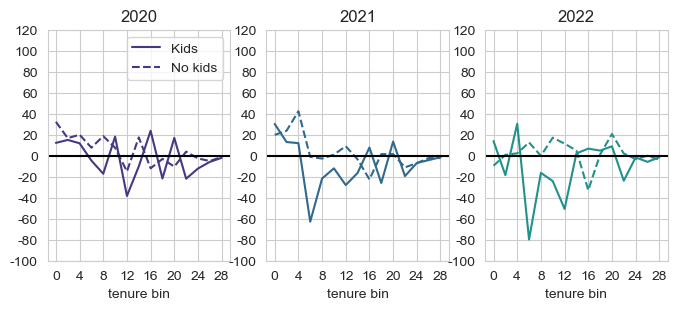

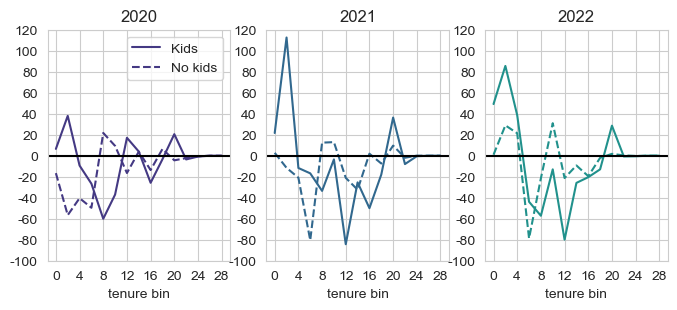

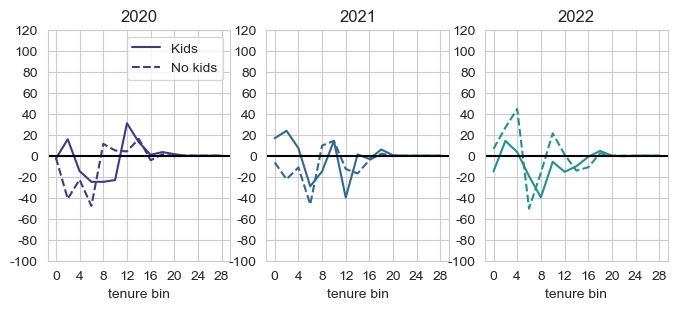

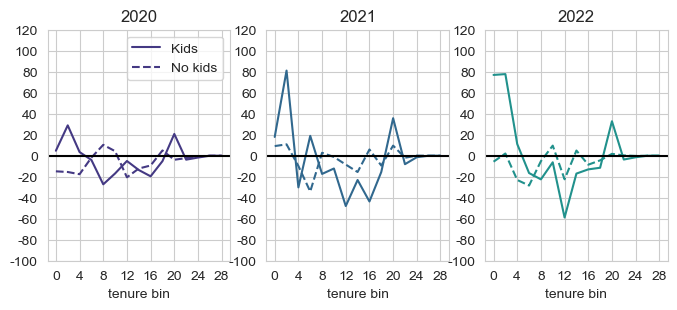

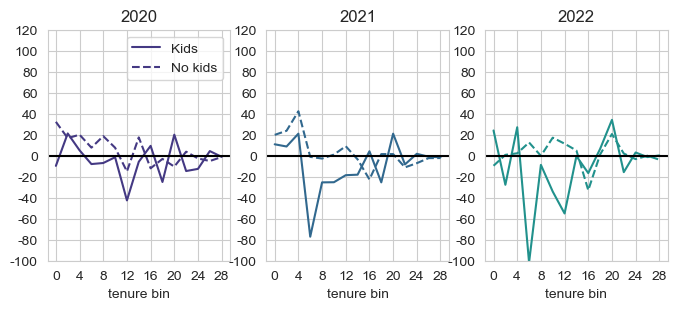

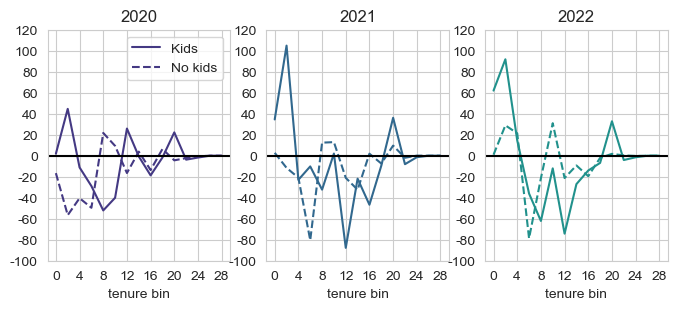

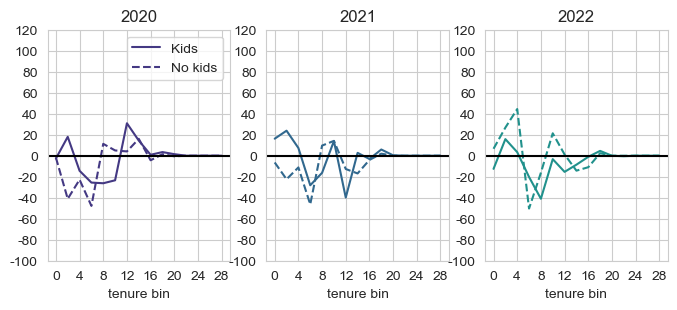

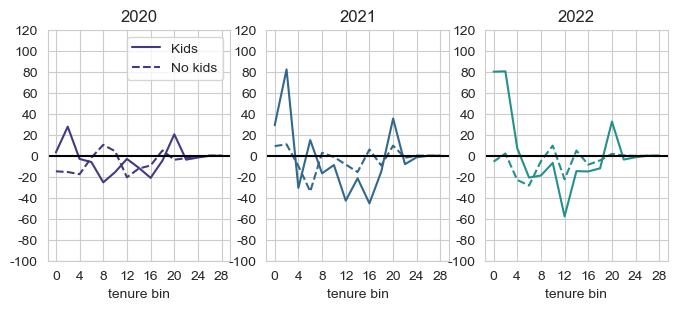

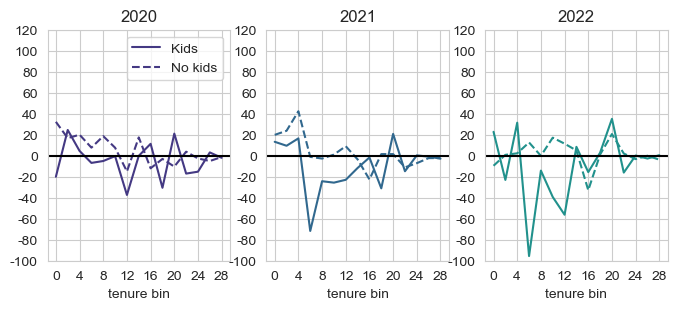

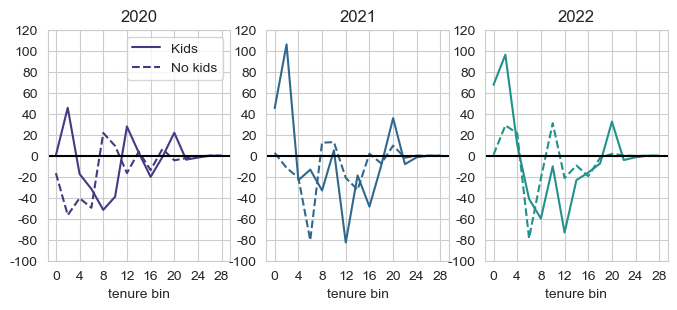

In [18]:
colors = sn.color_palette('viridis',Y-1)
years_sample_19 = years_sample[years_sample>2019]
Y19 = years_sample_19.size
parent_age_range = np.array([30,35,40,3040])

mux = pd.MultiIndex.from_product([kid_age_range,parent_age_range,years_sample_19,['men','women']])
MM = kid_age_range.size * (parent_age_range.size) * years_sample_19.size *2

export_data = np.zeros((T-1,MM))

ii = 0
for k_age in kid_age_range:
    for p_age in parent_age_range:

        hist_diff_gross_w_m, hist_diff_gross_w_m_0k = np.zeros((T-1,Y19)), np.zeros((T-1,Y19))
        hist_diff_gross_w_w, hist_diff_gross_w_w_0k = np.zeros((T-1,Y19)), np.zeros((T-1,Y19))
        for i,year in enumerate(years_sample_19):
            hist_diff_gross_w_w[:,i] = hist_dict_gross_w[k_age][p_age][year]['women']-hist_dict_gross_w[k_age][p_age][2019]['women']
            hist_diff_gross_w_m[:,i] = hist_dict_gross_w[k_age][p_age][year]['men']-hist_dict_gross_w[k_age][p_age][2019]['men']
            
            hist_diff_gross_w_w_0k[:,i] = hist_dict_gross_w_0k[p_age][year]['women']-hist_dict_gross_w_0k[p_age][2019]['women']
            hist_diff_gross_w_m_0k[:,i] = hist_dict_gross_w_0k[p_age][year]['men']-hist_dict_gross_w_0k[p_age][2019]['men']
            
            export_data[:,ii] = (hist_diff_gross_w_w[:,i]-hist_diff_gross_w_m[:,i])/100
            ii+=1
            export_data[:,ii] = (hist_diff_gross_w_w_0k[:,i]-hist_diff_gross_w_m_0k[:,i])/100
            ii+=1
            
        plt.figure(figsize=(8,3))
        name = 'parents {}-{}, kids <{}'.format(p_age,p_age+5,k_age)
#         plt.suptitle('Difference in change in distribution from 2019, {}'.format(name),fontsize=14,y=1.05)
        for i,year in enumerate(years_sample_19):
            plt.subplot(131+i)
            plt.title("{}".format(year))
            plt.plot(ten_range[:-1],(hist_diff_gross_w_w[:,i]-hist_diff_gross_w_m[:,i])/100,c=colors[i], label='Kids')
            plt.plot(ten_range[:-1],(hist_diff_gross_w_w_0k[:,i]-hist_diff_gross_w_m_0k[:,i])/100,c=colors[i],ls='--',label='No kids')
            plt.xticks(ten_range[::2])
            plt.xlabel('tenure bin')
            plt.axhline(0,c='k')
            plt.ylim(-1e5,1.2e5)
            plt.yticks(np.arange(-1e5,1.4e5,2e4),np.arange(-100,140,20))
            if i==0:
                plt.legend()
        plt.savefig(path+name.replace(" ","_").replace(",","").replace("<","")+'_2019_all_diff_kids_w.pdf',bbox_inches='tight')
        plt.show()

In [19]:
export_df = pd.DataFrame(export_data,columns=mux,index=ten_range[1:])
# mux2 = pd.MultiIndex.from_product([kid_age_range,parent_age_range,['women','men'],years_sample_19])

# export_df = export_df.T.set_index(mux2).T.astype(int)
export_df[10][30].to_csv('./other_data/hist/parents30_2019_all_diff_kids_w.csv')
export_df[10][35].to_csv('./other_data/hist/parents35_2019_all_diff_kids_w.csv')
export_df[10][3040].to_csv('./other_data/hist/parents3040_2019_all_diff_kids_w.csv')

export_df[10][30].to_latex('./other_data/hist/parents30_2019_all_diff_kids_w.tex')
export_df[10][35].to_latex('./other_data/hist/parents35_2019_all_diff_kids_w.tex')
export_df[10][3040].to_latex('./other_data/hist/parents3040_2019_all_diff_kids_w.tex')

C:\Users\lafuentemart\AppData\Local\Temp\ipykernel_8564\2530584387.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  export_df[10][30].to_latex('./other_data/hist/parents30_2019_all_diff_kids_w.tex')
C:\Users\lafuentemart\AppData\Local\Temp\ipykernel_8564\2530584387.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  export_df[10][35].to_latex('./other_data/hist/parents35_2019_all_diff_kids_w.tex')
C:\Users\lafuentemart\AppData\Local\Temp\ipykernel_8564\2530584387.py:11:

In [20]:
export_df

5                                                               \
        30                                                          35     
        2020                2021                2022                2020   
         men     women       men     women       men     women       men   
2    5089.89  -1719.81  17959.14  -6430.22  -9114.81   6627.41   1413.12   
4   12686.44 -41076.45  22095.33 -22400.60  13623.08  26798.26  25274.54   
6   -7453.45 -22796.28  11200.48 -11144.55   8659.53  44453.73  -1910.63   
8  -25778.85 -47785.81 -31052.58 -46350.17 -18054.27 -50304.11   -860.98   
10 -30713.49  11306.58 -18077.00   9650.65 -40776.07 -16208.03 -29316.29   
12 -22584.23   5022.19   9474.31  14136.44  -6329.16  21356.08 -14429.44   
14  34464.70   4086.85 -40245.18 -12655.52 -15072.18   1190.32 -17386.45   
16  12010.56  16076.46   1696.60 -16881.95 -10112.69 -14223.88  -8030.12   
18   1071.55  -4336.01  -2376.60  -4005.99   -699.36 -10949.18 -26854.07   
20   3475.82   1438.93   5917.69   1943.04   4608.52   2384.84  -6837.73   
22   1480.49   -554.89    384.21      0.00    -16.60      0.00  19049.19   
24      0.00      0.00      0.00      0.00   -460.58      0.00  -3543.83   
26      0.00      0.00      0.00      0.00      0.00      0.00   -774.41   
28      0.00      0.00      0.00      0.00      0.00      0.00      0.00   
30      0.00      0.00      0.00      0.00      0.00      0.00      0.00   

                                  ...        15                                \
                                  ...      40                                   
                  2021            ...      2021                2022             
       women       men     women  ...       men     women       men     women   
2  -14863.14   3659.01   9177.60  ...  13267.31  19849.95  22765.99  -9556.21   
4  -15499.42  90490.85  10833.09  ...   9495.14  23753.99 -23052.15    819.34   
6  -17616.30 -22893.18  -9769.07  ...  16515.99  42345.04  31451.88   2294.15   
8   -1785.16  14276.90 -34109.98  ... -71666.74  -1083.27 -95556.99  12626.50   
10  10370.33 -15422.79   2790.19  ... -24293.58  -2706.41 -14175.95   -114.71   
12   4333.10 -12979.06  -1177.67  ... -25634.78   1087.24 -39292.97  17187.41   
14 -20563.54 -44033.68  -8427.63  ... -22927.10   9045.63 -56207.79  11469.77   
16 -12193.18 -27076.86 -15499.13  ... -11675.51  -3485.36   8458.36   4998.97   
18  -9309.49 -47575.76   5936.06  ...  -1700.74 -22571.21 -15600.41 -32849.51   
20   4998.06 -23891.68  -9372.89  ... -31068.07   1526.85   2884.68   1121.61   
22  -3842.93  35975.60   9644.68  ...  20794.47   1541.78  35109.87  20639.60   
24  -2246.42  -7958.86  -1936.77  ... -14777.11 -11095.23 -16057.13   2075.38   
26   -560.43   -453.33     80.94  ...    314.87  -7092.38    193.00  -3247.90   
28      0.00      0.00      0.00  ...   -904.42  -2282.86  -2711.11    -19.19   
30      0.00      0.00      0.00  ...  -2799.03  -2207.51    507.73  -3758.82   

                                                                 
        3040                                                     
        2020                 2021                2022            
         men     women        men     women       men     women  
2     379.70 -16582.95   45295.20   2747.38  67514.38    948.20  
4   45664.95 -56575.87  106016.49 -11567.51  96199.66  28918.97  
6  -17366.36 -40412.58  -23322.89 -20913.62  10665.78  21371.73  
8  -31653.50 -49570.97  -13243.39 -80460.15 -41061.33 -78703.24  
10 -51570.00  21676.91  -33093.16  12440.84 -59816.88 -21428.79  
12 -39041.93   9355.29    5136.42  12958.77 -10087.50  30978.30  
14  27838.61 -16476.69  -82588.30 -21083.15 -73153.27 -21260.25  
16   2913.26   3883.28  -18760.88 -32381.08 -23202.26  -9288.76  
18 -20189.59 -13645.50  -48498.07   1930.07 -16049.48 -19489.09  
20  -1172.38   6436.99   -9151.48  -7429.85  -7381.47  -2038.38  
22  21896.42  -4397.82   35806.00   9644.68  32481.38   1787.39  
24  -3755.87  -2246.42   -8070.27  

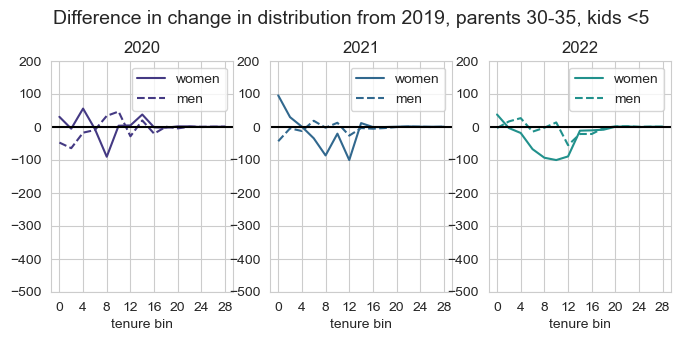

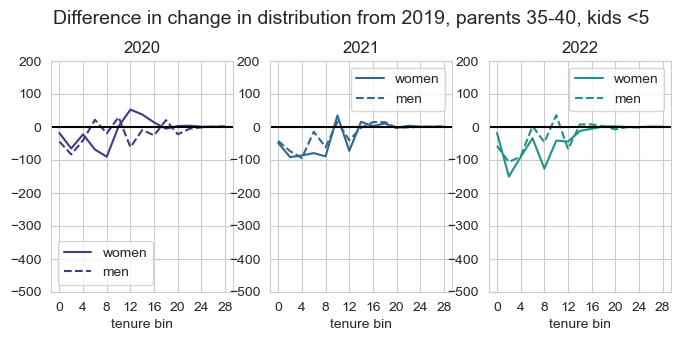

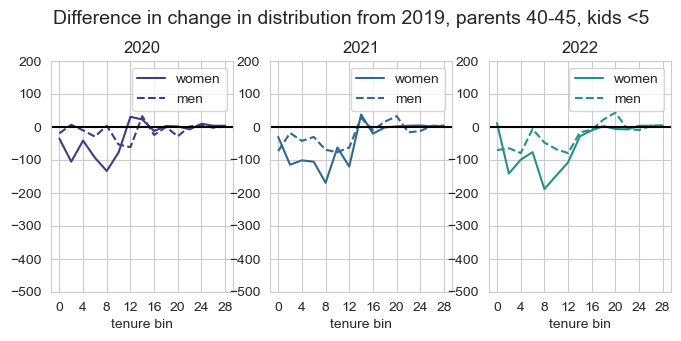

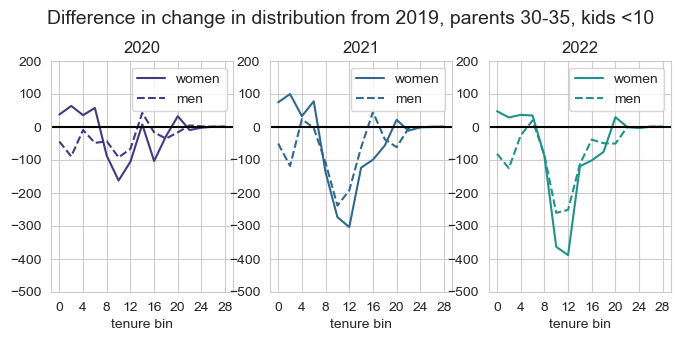

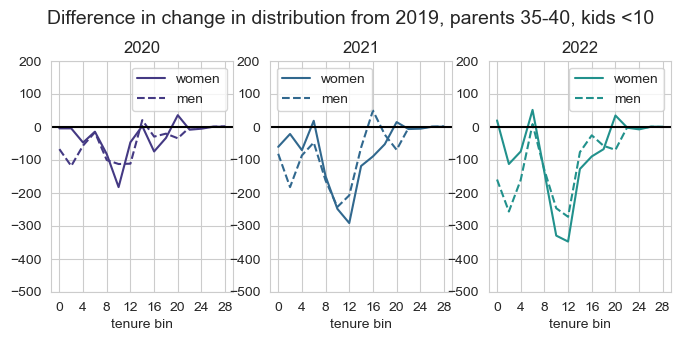

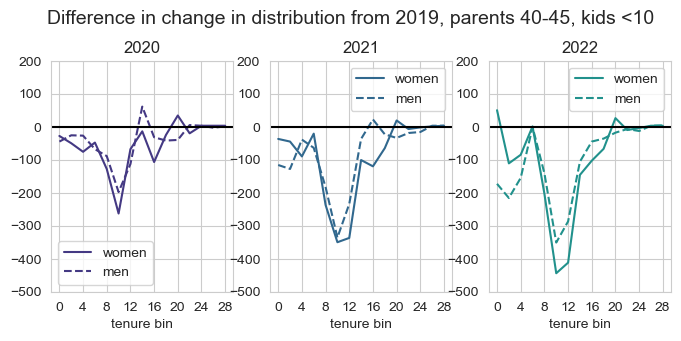

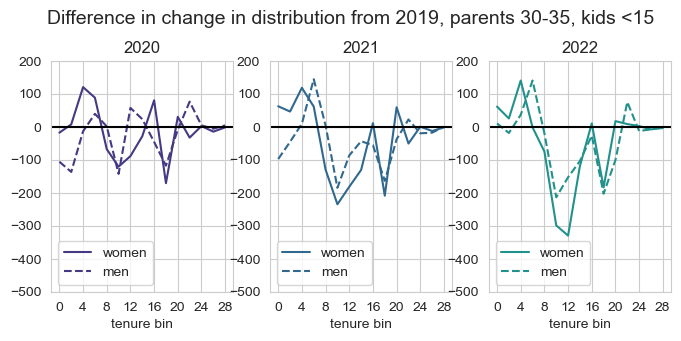

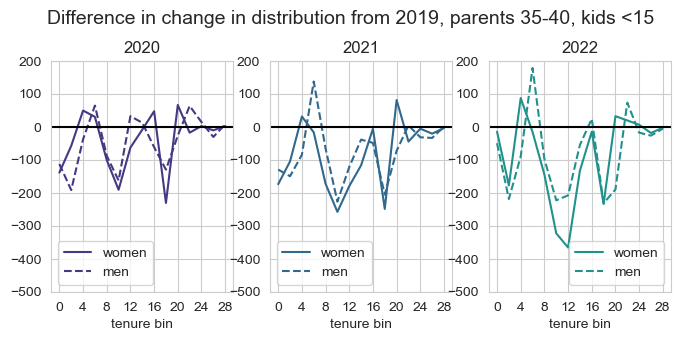

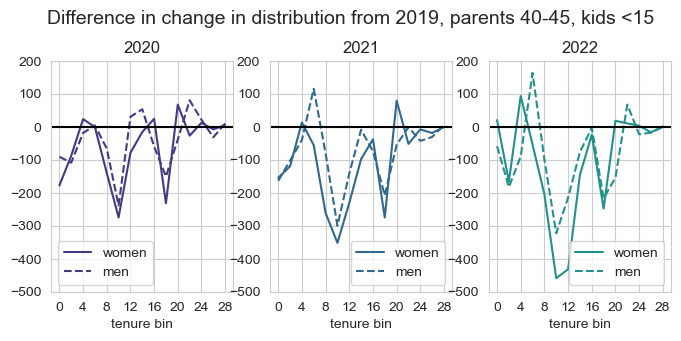

In [7]:
colors = sn.color_palette('viridis',Y-1)
years_sample_19 = years_sample[years_sample>2019]
Y19 = years_sample_19.size

for k_age in kid_age_range:
    for p_age in parent_age_range:

        hist_diff_gross_m, hist_diff_gross_m_0k = np.zeros((T-1,Y19)), np.zeros((T-1,Y19))
        hist_diff_gross_w, hist_diff_gross_w_0k = np.zeros((T-1,Y19)), np.zeros((T-1,Y19))
        for i,year in enumerate(years_sample_19):
            hist_diff_gross_w[:,i] = hist_dict_gross[p_age][k_age][year]['women']-hist_dict_gross[p_age][k_age][2019]['women']
            hist_diff_gross_m[:,i] = hist_dict_gross[p_age][k_age][year]['men']-hist_dict_gross[p_age][k_age][2019]['men']
            
            hist_diff_gross_w_0k[:,i] = hist_dict_gross_0k[p_age][year]['women']-hist_dict_gross_0k[p_age][2019]['women']
            hist_diff_gross_m_0k[:,i] = hist_dict_gross_0k[p_age][year]['men']-hist_dict_gross_0k[p_age][2019]['men']

        plt.figure(figsize=(8,3))
        name = 'parents {}-{}, kids <{}'.format(p_age,p_age+5,k_age)
        plt.suptitle('Difference in change in distribution from 2019, {}'.format(name),fontsize=14,y=1.05)
        for i,year in enumerate(years_sample_19):
            plt.subplot(131+i)
            plt.title("{}".format(year))
            plt.plot(ten_range[:-1],hist_diff_gross_w[:,i]-hist_diff_gross_w_0k[:,i],c=colors[i], label='women')
            plt.plot(ten_range[:-1],hist_diff_gross_m[:,i]-hist_diff_gross_m_0k[:,i],c=colors[i],ls='--',label='men')
            plt.xticks(ten_range[::2])
            plt.xlabel('tenure bin')
            plt.axhline(0,c='k')
            plt.ylim(-500,200)
            plt.legend()
        plt.savefig(path+name.replace(" ","_").replace(",","").replace("<","")+'_2019_all_diff_childpenalty.pdf',bbox_inches='tight')
        plt.show()

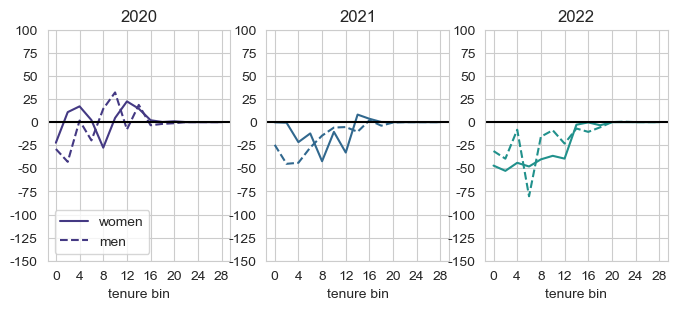

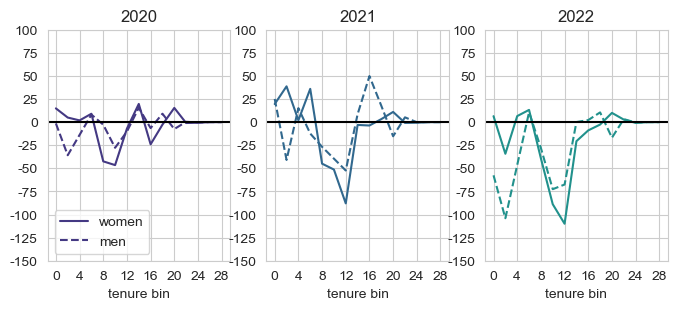

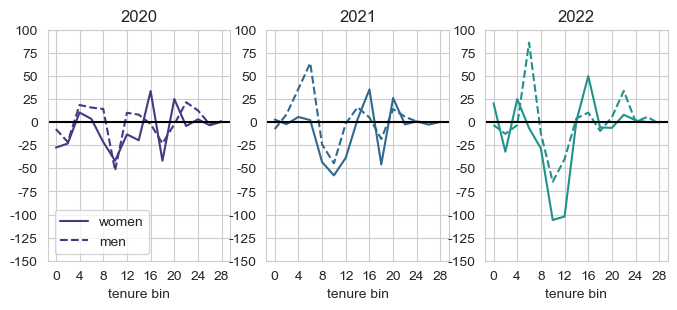

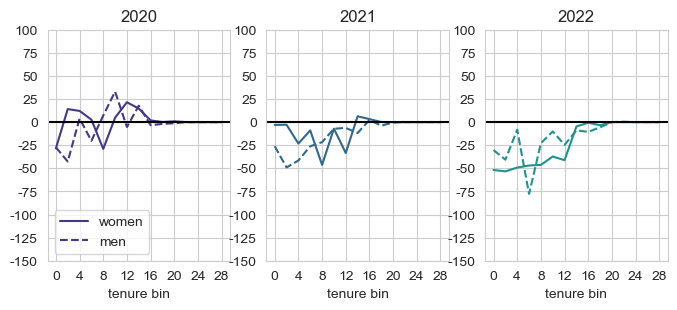

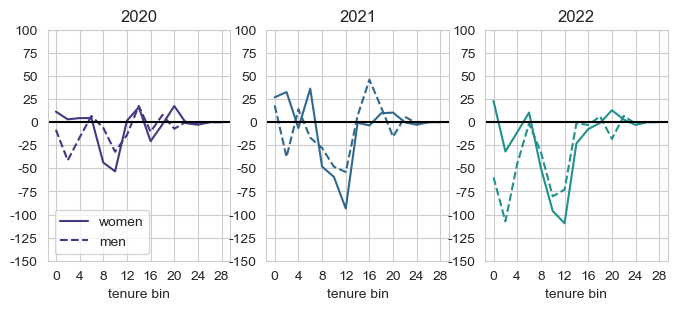

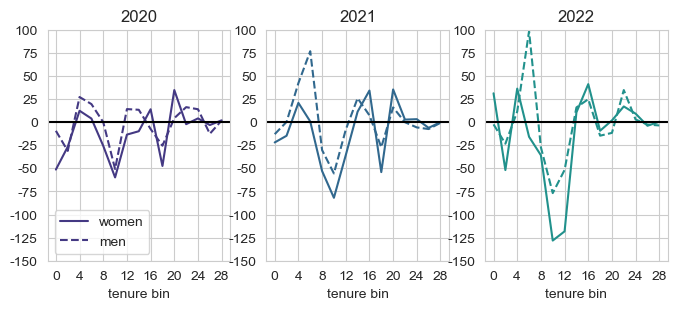

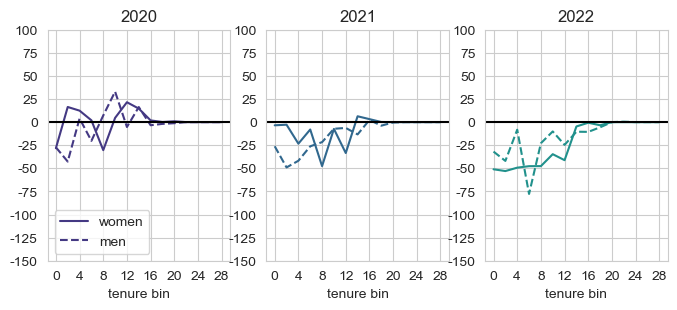

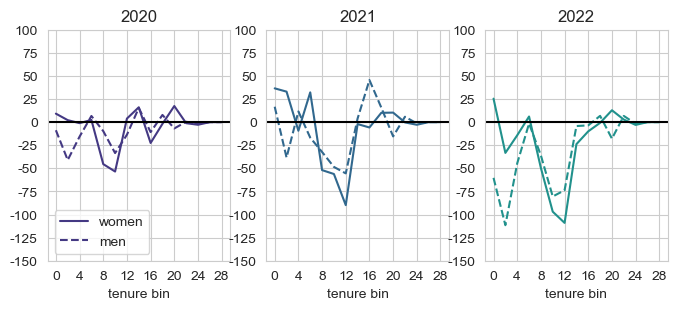

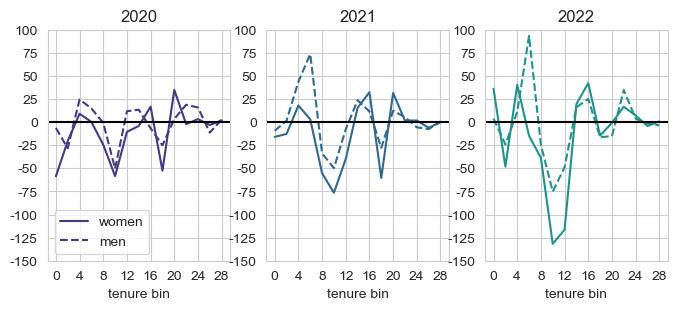

In [118]:
colors = sn.color_palette('viridis',Y-1)
years_sample_19 = years_sample[years_sample>2019]
Y19 = years_sample_19.size

for k_age in kid_age_range:
    for p_age in parent_age_range:

        hist_diff_gross_w_m,hist_diff_gross_w_m_0k = np.zeros((T-1,Y19)), np.zeros((T-1,Y19))
        hist_diff_gross_w_w,hist_diff_gross_w_w_0k = np.zeros((T-1,Y19)), np.zeros((T-1,Y19))
        for i,year in enumerate(years_sample_19):
            hist_diff_gross_w_w[:,i] = hist_dict_gross_w[k_age][p_age][year]['women']-hist_dict_gross_w[k_age][p_age][2019]['women']
            hist_diff_gross_w_m[:,i] = hist_dict_gross_w[k_age][p_age][year]['men']-hist_dict_gross_w[k_age][p_age][2019]['men']
            
            hist_diff_gross_w_w_0k[:,i] = hist_dict_gross_w_0k[p_age][year]['women']-hist_dict_gross_w_0k[p_age][2019]['women']
            hist_diff_gross_w_m_0k[:,i] = hist_dict_gross_w_0k[p_age][year]['men']-hist_dict_gross_w_0k[p_age][2019]['men']
        plt.figure(figsize=(8,3))
        name = 'parents vs non parents, \n age {}-{}, kids <{}'.format(p_age,p_age+5,k_age)
#         plt.suptitle('Difference in change in distribution from 2019, {}'.format(name),fontsize=14,y=1.1)
        for i,year in enumerate(years_sample_19):
            plt.subplot(131+i)
            plt.title("{}".format(year))
            plt.plot(ten_range[:-1],(hist_diff_gross_w_w[:,i]-hist_diff_gross_w_w_0k[:,i])/100,c=colors[i],label='women')
            plt.plot(ten_range[:-1],(hist_diff_gross_w_m[:,i]-hist_diff_gross_w_m_0k[:,i])/100,c=colors[i],ls='--',label='men')
            plt.xticks(ten_range[::2])
            plt.yticks(np.arange(-1.5e5,1.25e5,2.5e4),np.arange(-150,125,25))
            plt.xlabel('tenure bin')
            plt.axhline(0,c='k')
            plt.ylim(-1.5e5,1e5)
            if i==0:
                plt.legend(loc='lower left')
        plt.savefig(path+name.replace("\n","").replace(" ","_").replace(",","").replace("<","")+'_2019_all_diff_weighted_cp.pdf',bbox_inches='tight')
        plt.show()

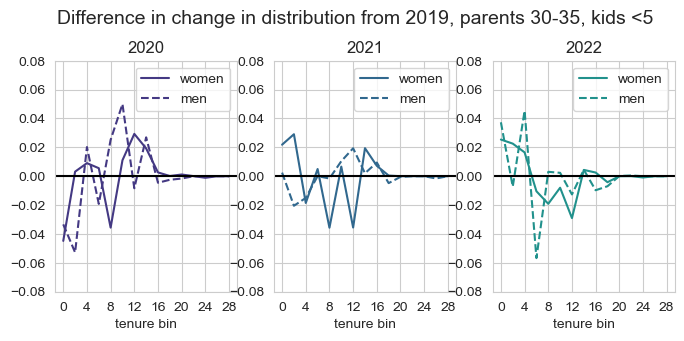

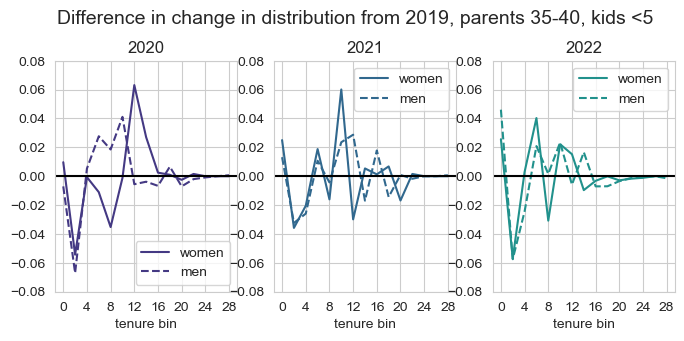

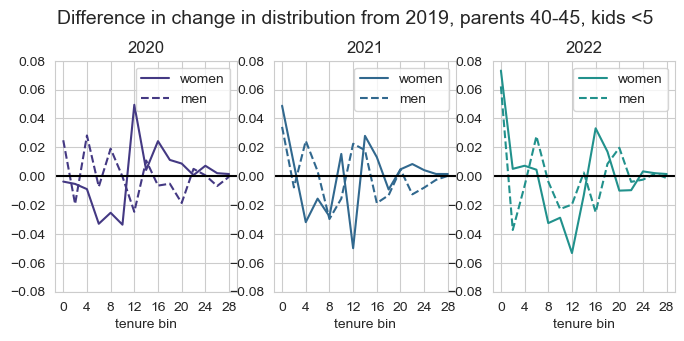

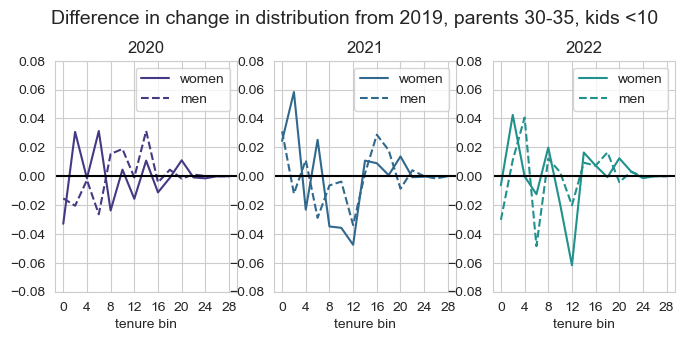

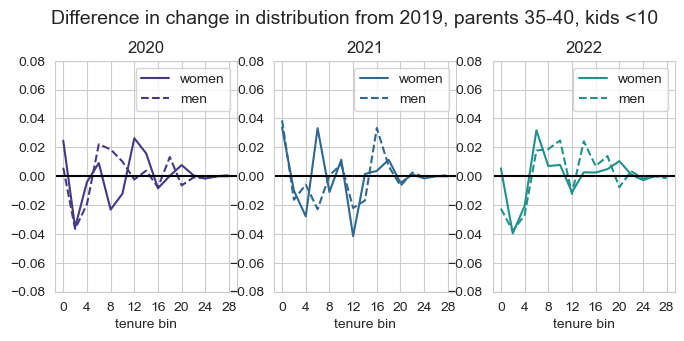

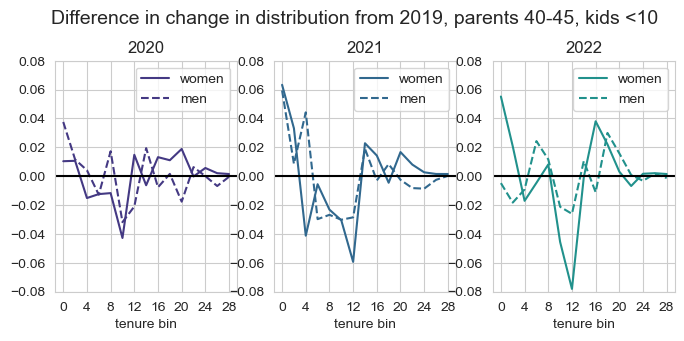

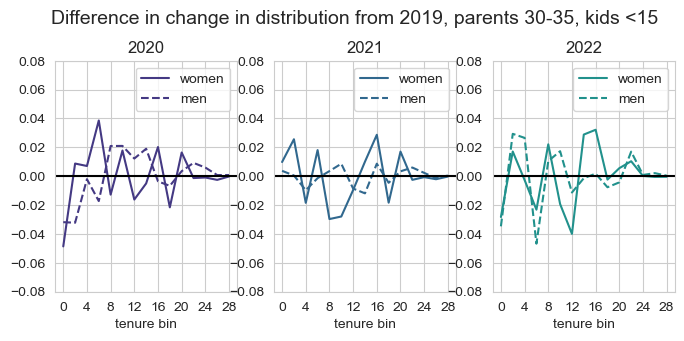

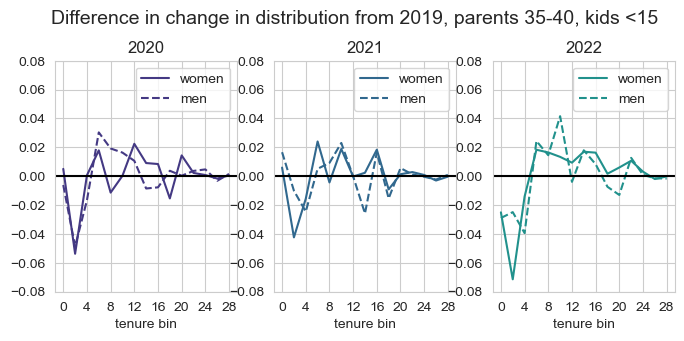

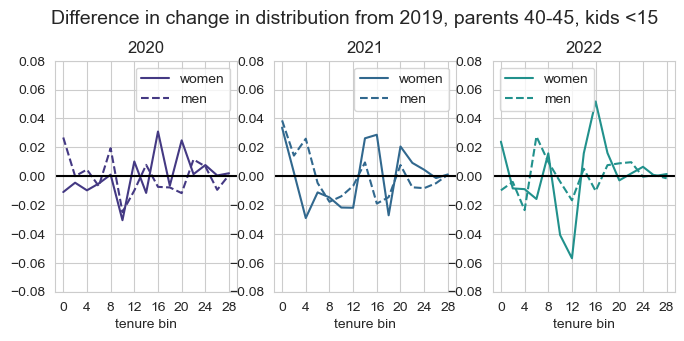

In [35]:
colors = sn.color_palette('viridis',Y-1)
years_sample_19 = years_sample[years_sample>2019]
Y19 = years_sample_19.size

for k_age in kid_age_range:
    for p_age in parent_age_range:

        hist_diff_w_m, hist_diff_w_m_0k = np.zeros((T-1,Y19)), np.zeros((T-1,Y19))
        hist_diff_w_w, hist_diff_w_w_0k = np.zeros((T-1,Y19)), np.zeros((T-1,Y19))
        for i,year in enumerate(years_sample_19):
            hist_diff_w_w[:,i] = hist_dict_w[p_age][k_age][year]['women']-hist_dict_w[p_age][k_age][2019]['women']
            hist_diff_w_m[:,i] = hist_dict_w[p_age][k_age][year]['men']-hist_dict_w[p_age][k_age][2019]['men']
            
            hist_diff_w_w_0k[:,i] = hist_dict_w_0k[p_age][year]['women']-hist_dict_w_0k[p_age][2019]['women']
            hist_diff_w_m_0k[:,i] = hist_dict_w_0k[p_age][year]['men']-hist_dict_w_0k[p_age][2019]['men']

        plt.figure(figsize=(8,3))
        name = 'parents {}-{}, kids <{}'.format(p_age,p_age+5,k_age)
        plt.suptitle('Difference in change in distribution from 2019, {}'.format(name),fontsize=14,y=1.05)
        for i,year in enumerate(years_sample_19):
            plt.subplot(131+i)
            plt.title("{}".format(year))
            plt.plot(ten_range[:-1],(hist_diff_w_w[:,i]-hist_diff_w_w_0k[:,i]),c=colors[i],label='women')
            plt.plot(ten_range[:-1],(hist_diff_w_m[:,i]-hist_diff_w_m_0k[:,i]),c=colors[i],ls='--',label='men')
            plt.xticks(ten_range[::2])
            plt.xlabel('tenure bin')
            plt.axhline(0,c='k')
            plt.ylim(-0.08,0.08)
            plt.legend()
        plt.savefig(path+name.replace(" ","_").replace(",","").replace("<","")+'_2019_all_diff_relative_weighted_cp.pdf',bbox_inches='tight')
        plt.show()

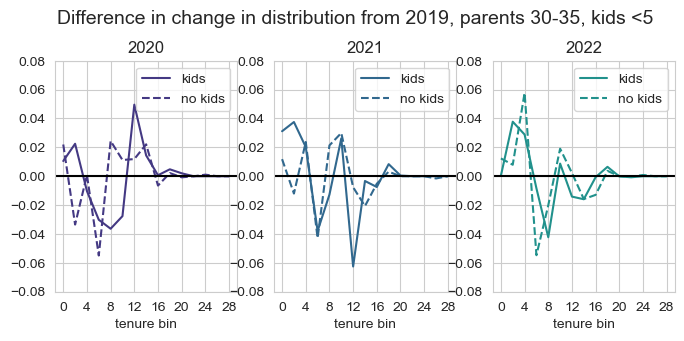

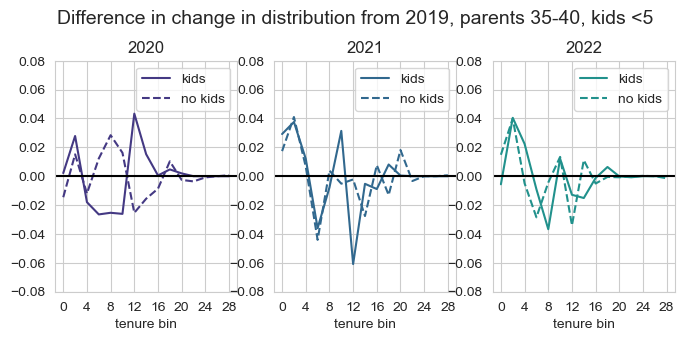

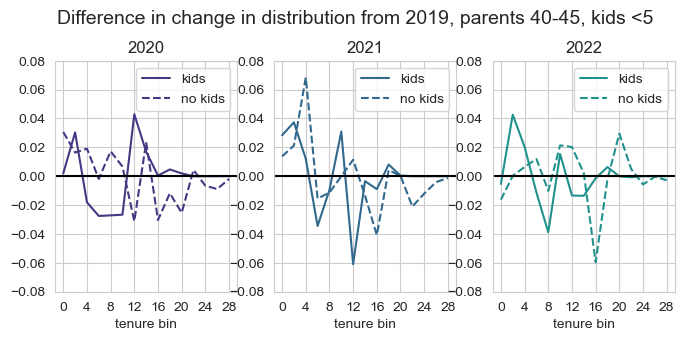

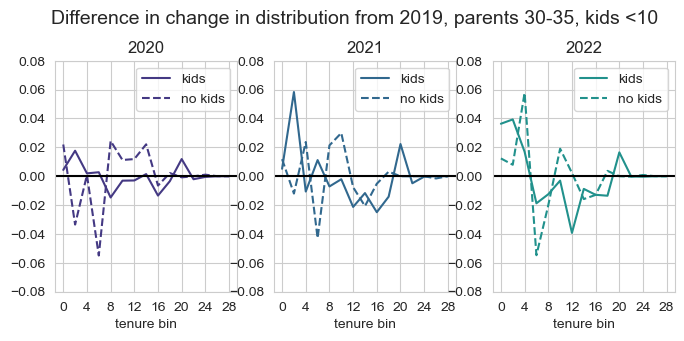

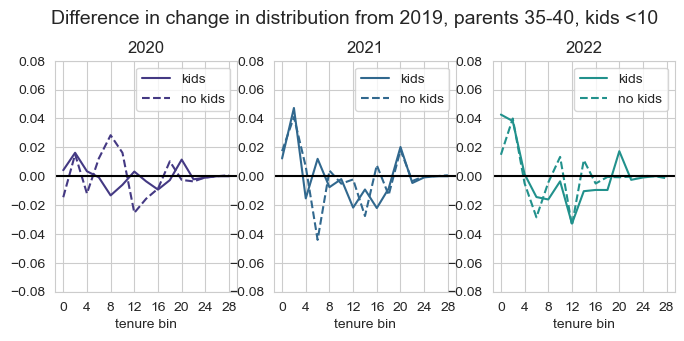

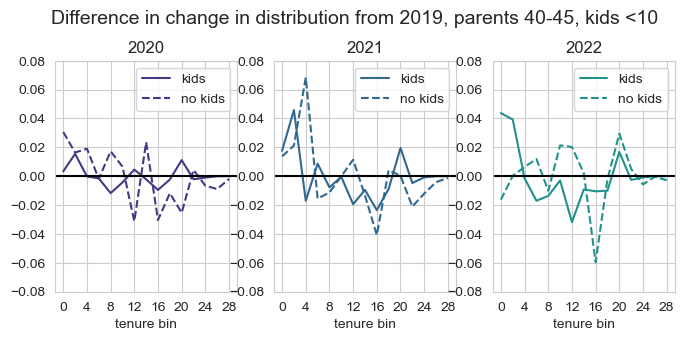

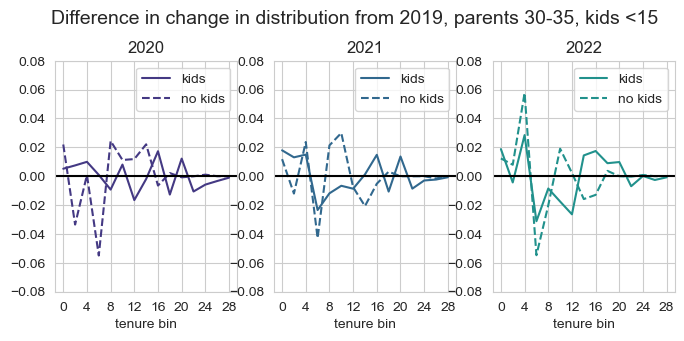

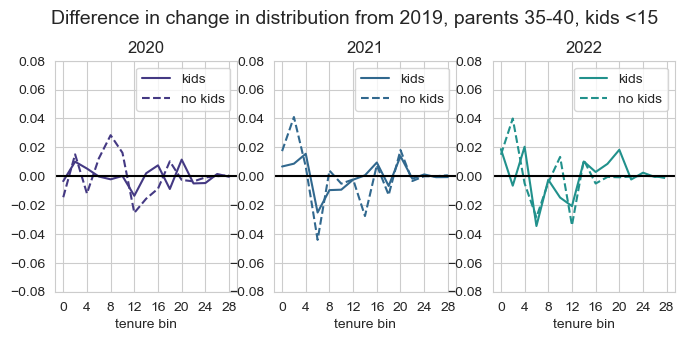

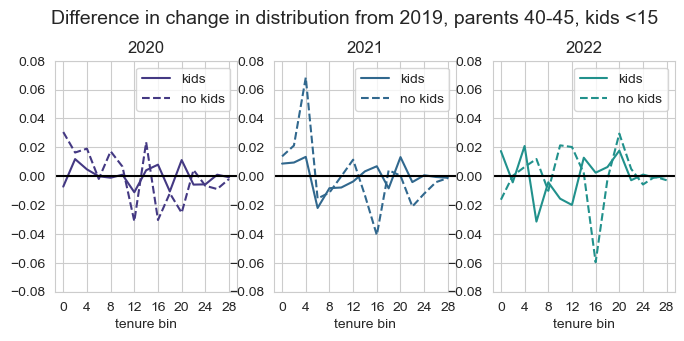

In [36]:
colors = sn.color_palette('viridis',Y-1)
years_sample_19 = years_sample[years_sample>2019]
Y19 = years_sample_19.size

for k_age in kid_age_range:
    for p_age in parent_age_range:

        hist_diff_w_m, hist_diff_w_m_0k = np.zeros((T-1,Y19)), np.zeros((T-1,Y19))
        hist_diff_w_w, hist_diff_w_w_0k = np.zeros((T-1,Y19)), np.zeros((T-1,Y19))
        for i,year in enumerate(years_sample_19):
            hist_diff_w_w[:,i] = hist_dict_w[p_age][k_age][year]['women']-hist_dict_w[p_age][k_age][2019]['women']
            hist_diff_w_m[:,i] = hist_dict_w[p_age][k_age][year]['men']-hist_dict_w[p_age][k_age][2019]['men']
            
            hist_diff_w_w_0k[:,i] = hist_dict_w_0k[p_age][year]['women']-hist_dict_w_0k[p_age][2019]['women']
            hist_diff_w_m_0k[:,i] = hist_dict_w_0k[p_age][year]['men']-hist_dict_w_0k[p_age][2019]['men']

        plt.figure(figsize=(8,3))
        name = 'parents {}-{}, kids <{}'.format(p_age,p_age+5,k_age)
        plt.suptitle('Difference in change in distribution from 2019, {}'.format(name),fontsize=14,y=1.05)
        for i,year in enumerate(years_sample_19):
            plt.subplot(131+i)
            plt.title("{}".format(year))
            plt.plot(ten_range[:-1],(hist_diff_w_w[:,i]-hist_diff_w_m[:,i]),c=colors[i],label='kids')
            plt.plot(ten_range[:-1],(hist_diff_w_w_0k[:,i]-hist_diff_w_m_0k[:,i]),c=colors[i],ls='--',label='no kids')
            plt.xticks(ten_range[::2])
            plt.xlabel('tenure bin')
            plt.axhline(0,c='k')
            plt.ylim(-0.08,0.08)
            plt.legend()
        plt.savefig(path+name.replace(" ","_").replace(",","").replace("<","")+'_2019_all_diff_relative_weighted.pdf',bbox_inches='tight')
        plt.show()